# Diffractive and Non- Diffractive ODT Reconstruction Simulations

This code simulate the non-diffracting tomographic reconstruction of an object using filtered backprojection and Fourier interpolation. We will late also compare with diffraction algorithms.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import plotly.graph_objects as go
import time
import sys
import os
from time import time
from mpl_toolkits import mplot3d
from IPython.display import display, Latex
from skimage.transform import radon, rescale, iradon
from scipy.interpolate import griddata
from scipy.ndimage import rotate
from skimage.metrics import structural_similarity
from skimage.metrics import normalized_root_mse

sys.path.append(os.path.abspath("..")) 
from src.helpers.noise import additive_noise

This script generates a 3D cylinder, texture, artifacts and noise can be later added on the basic shape. We also generate detector's plan and set projection number.

In [2]:
n_obj = 1.38                                # Refractive index of the object
n_med = 1.33                                # Refractive index of the medium
nproj = 128                                 # Number of projections
L = 10e-3                                   # 10 mm object field of view
N = 128                                     # number of pixels of the object
a = 1.5e-3
b = 2e-3  
c = 2.5e-3                                  # axes of the elliptical cylinder
height = 5e-3                               # cylinder height along z
rho = n_obj - n_med                         # contrast
wavelength = 532e-9                         # Wavelength [m]

#--------------------------------------------------
# Grid - real coordinates and fourier space
#--------------------------------------------------

deltax = L/N
x = deltax * np.linspace(-N/2, (N/2)-1, N)
y = x.copy()
z = np.linspace(-height/2, height/2, N)
fx=np.linspace(-1/2/deltax, 1/2/deltax-1/L, N)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
Fx, Fy, Fz = np.meshgrid(fx, fx, fx, indexing='ij')

# --------------------------------------------------
# 3D Object: finite elipsoide and its FT
# --------------------------------------------------
mask = ((X/a)**2 + (Y/b)**2  + (Z/c) ** 2 <= 1) 
object3D = rho * mask.astype(float)

object3DFT = np.zeros((N, N, N), dtype=complex)

for i in range(N):
    object3DFT[:, :, i] = np.fft.fftshift(
        np.fft.fft2(np.fft.fftshift(object3D[:, :, i]))
    ) * (deltax**2)


In [7]:
# --------------------------------------------------
# Analytical 2D projections for an ellipsoid (rotating in x–y plane)
# --------------------------------------------------
angles = np.linspace(0, 180, nproj, endpoint=False)

# --------------------------------------------------
# Function: Analytical 2D projections for an ellipsoid (rotating in x–y plane)
# --------------------------------------------------
def create_projections(nproj):
    angles = np.linspace(0, 180, nproj, endpoint=False)  # define angles *inside* the function
    projections_2D = []
    projections_2D_FT = []

    for theta in angles:
        theta_rad = np.deg2rad(theta)
        cos_t, sin_t = np.cos(theta_rad), np.sin(theta_rad)

        projection = np.zeros((len(y), len(z)))  # y × z

        for k, z_val in enumerate(z):
            s = 1.0 - (z_val / c)**2
            if s <= 0:
                continue  # outside ellipsoid

            a_z = a * np.sqrt(s)
            b_z = b * np.sqrt(s)
            a2theta_z = (a_z**2 * cos_t**2 + b_z**2 * sin_t**2)

            for i, y_val in enumerate(y):
                t_val = y_val
                if t_val**2 <= a2theta_z:
                    val = 2.0 * rho * a_z * b_z * np.sqrt(a2theta_z - t_val**2) / a2theta_z
                    projection[i, k] = val

        projectionFT = (deltax**2) * np.fft.fftshift(np.fft.fft2(np.fft.fftshift(projection)))
        projections_2D.append(projection)
        projections_2D_FT.append(projectionFT)

    projections_2D = np.array(projections_2D)        # (nproj, Ny, Nz)
    projections_2D_FT = np.array(projections_2D_FT)  # (nproj, Ny, Nz)
    sinogram3D = projections_2D

    return projections_2D, projections_2D_FT, sinogram3D, angles



projections_2D, projections_2D_FT, sinogram3D, angles = create_projections(nproj)
    


<Figure size 2000x1200 with 0 Axes>

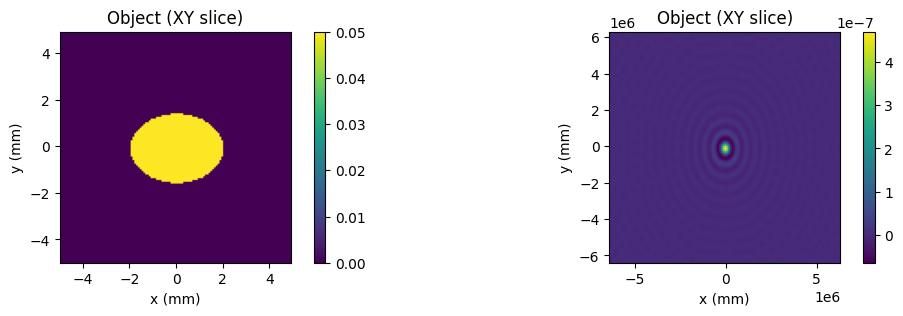

/home/oheymans/ODT_simulations/env/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/oheymans/ODT_simulations/env/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


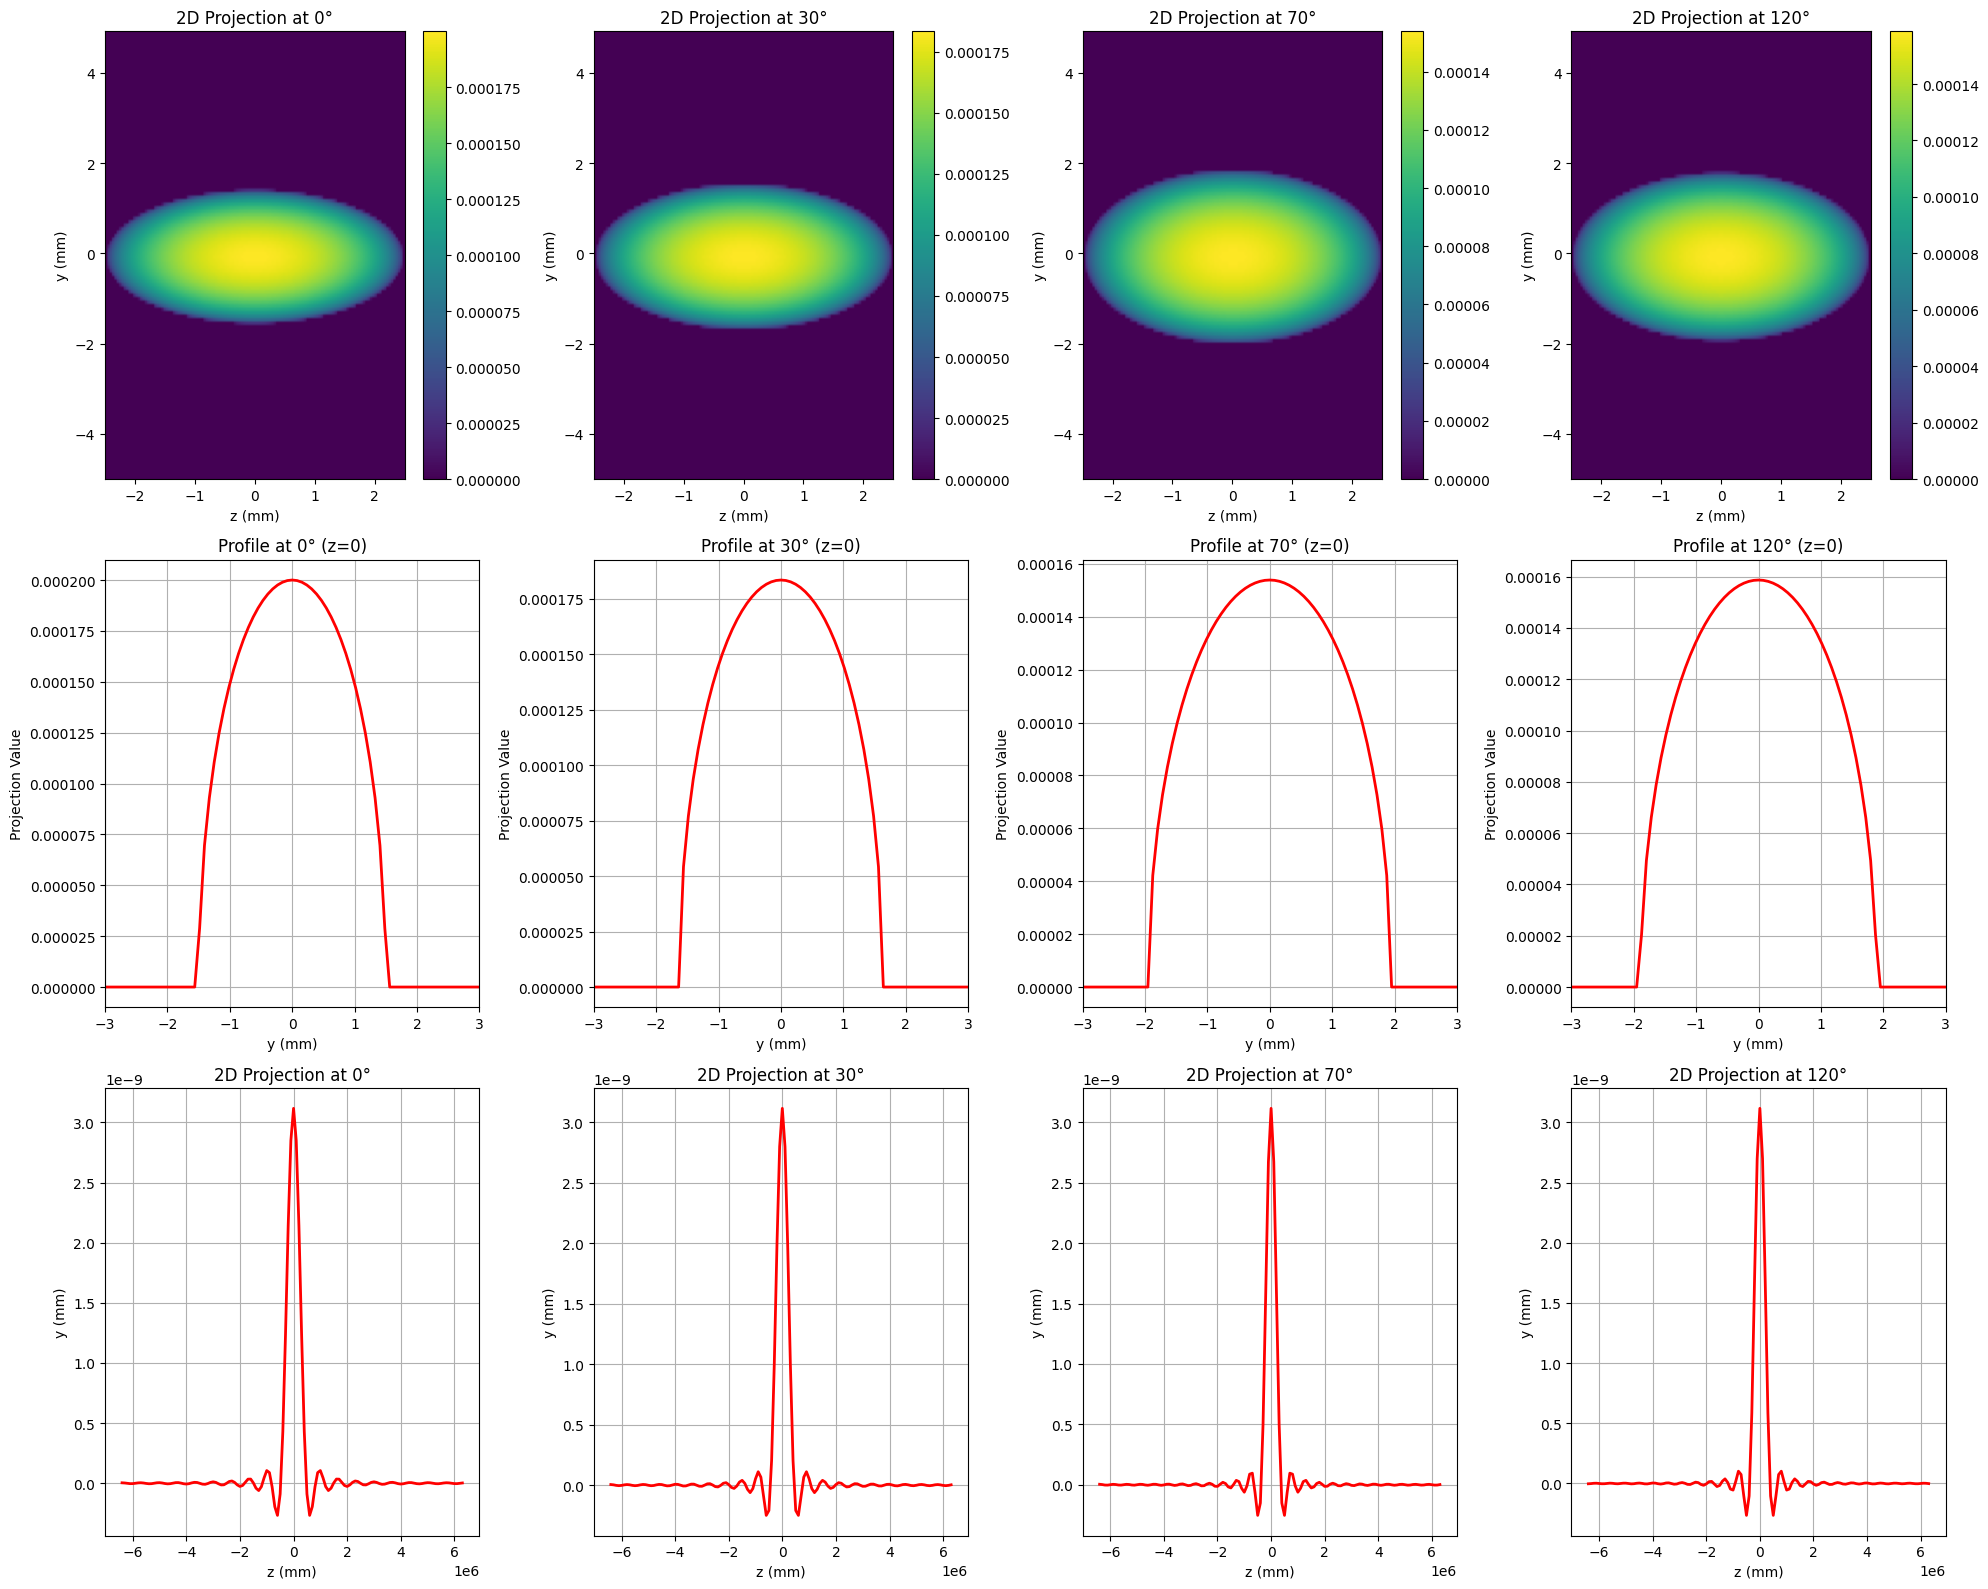

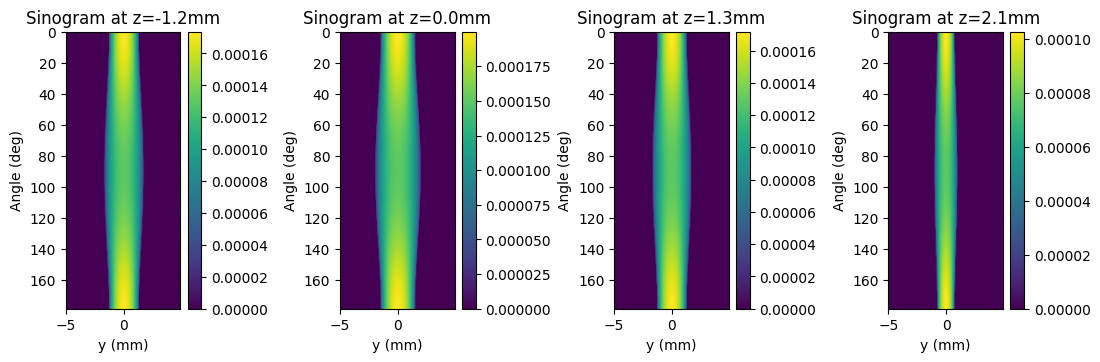

In [8]:
# --------------------------------------------------
# Visualization 
# --------------------------------------------------
fig = plt.figure(figsize=(20, 12))
object_slice = object3D[:, :, N//2]
object_FT_slice = object3DFT[:, :, N//2]



# 1) Object slice (XY)
fig = plt.figure(figsize=[13,3])

plt.subplot(1, 2, 1)
plt.imshow(object_slice, extent=[x[0]*1e3, x[-1]*1e3, y[0]*1e3, y[-1]*1e3])
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Object (XY slice)')
plt.colorbar()

plt.subplot(1, 2, 2)
object_slice = ((x[:, None]/a)**2 + (y[None, :]/b)**2 <= 1)
plt.imshow(np.real(object_FT_slice), extent=[fx[0]*1e3, fx[-1]*1e3, fx[0]*1e3, fx[-1]*1e3])
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Object (XY slice)')
plt.colorbar()


plt.show()

# 2) 2D projections + profiles
selected_angles = [0, 30, 70, 120]
selected_indices = [np.argmin(np.abs(angles - ang)) for ang in selected_angles]

fig = plt.figure(figsize=[20,16])
for i, (angle, idx) in enumerate(zip(selected_angles, selected_indices)):
    plt.subplot(3, 4, i + 1)  
    im = plt.imshow(projections_2D[idx], cmap='viridis',
                    extent=[z[0]*1e3, z[-1]*1e3, y[0]*1e3, y[-1]*1e3],
                    aspect='auto')
    plt.xlabel('z (mm)')
    plt.ylabel('y (mm)')
    plt.title(f'2D Projection at {angle}°')
    plt.colorbar(im)


for i, (angle, idx) in enumerate(zip(selected_angles, selected_indices)):
    plt.subplot(3, 4, i + 5)  
    profile = projections_2D[idx][:, len(z)//2]
    plt.plot(y*1e3, profile, 'r-', linewidth=2)
    plt.xlabel('y (mm)')
    plt.ylabel('Projection Value')
    plt.title(f'Profile at {angle}° (z=0)')
    plt.grid(True)
    plt.xlim(-3, 3)

for i, (angle, idx) in enumerate(zip(selected_angles, selected_indices)):
    plt.subplot(3, 4, i + 9) 
    profile_FT = projections_2D_FT[idx][:, len(z)//2] 
    plt.plot(fx*1e3, profile_FT, 'r-', linewidth=2)
    plt.xlabel('z (mm)')
    plt.ylabel('y (mm)')
    plt.grid(True)
    plt.title(f'2D Projection at {angle}°')


plt.tight_layout()
plt.show()

# 3) 2D Sinograms
fig = plt.figure(figsize=[16,10])
z_slices = [N//4, N//2, 3*N//4, N-10]
for i, z_slice in enumerate(z_slices):
    plt.subplot(3, 6, i+1)
    sinogram_2d = sinogram3D[:, :, z_slice]
    im = plt.imshow(sinogram_2d, cmap='viridis', aspect='auto',
                   extent=[y[0]*1e3, y[-1]*1e3, angles[-1], angles[0]])
    plt.xlabel('y (mm)')
    plt.ylabel('Angle (deg)')
    plt.title(f'Sinogram at z={z[z_slice]*1e3:.1f}mm')
    plt.colorbar(im)
plt.tight_layout()
plt.show()


In [9]:
def fbp_reconstruct(sinogram3D, angles, nproj, z, y, filter_name='shepp-logan'):
    """
    Perform FBP reconstruction for all z slices.
    Returns:
        recon3D: reconstructed volume (Ny, Ny, Nz)
        fbp_time: reconstruction time in seconds
    """
    import numpy as np
    from skimage.transform import iradon
    import time

    angles_deg = np.asarray(angles)
    Nz = len(z)
    Ny = len(y)

    # If 0..360 coverage, use half (iradon expects 0..180 unique)
    if angles_deg.max() > 180 + 1e-6:
        n_iradon = nproj // 2
        used_angles = np.linspace(0, 180, n_iradon, endpoint=False)
    else:
        n_iradon = nproj
        used_angles = angles_deg

    recon3D = np.zeros((Ny, Ny, Nz))   # (y, x, z)

    start = time.time()
    for zi in range(Nz):
        sino2D = sinogram3D[:, :, zi]
        sino_iradon = sino2D[:n_iradon, :].T if angles_deg.max() > 180 else sino2D.T   # transpose for iradon

        recon_slice = iradon(
            sino_iradon,
            theta=used_angles,
            filter_name=filter_name,
            circle=True
        )

        recon3D[:, :, zi] = recon_slice.T           # transpose back for orientation consistency

    end = time.time()
    fbp_time = end - start
    return recon3D, fbp_time   

recon3D, fbp_time = fbp_reconstruct(sinogram3D, angles, nproj, z, y)                             


In [10]:
def ft_interpolation_reconstruct(projections_2D, angles, nproj, y, z, object3D, deltax, method='cubic', mask_radius=1.5):
    """
    Reconstruct object using Fourier interpolation for all z slices.
    Returns:
        object_recon: reconstructed volume (Nx, Ny, Nz)
        FT_recon_time: reconstruction time in seconds
        datafx, datafy: polar frequency coordinates (nproj, Ny)
    """
    import numpy as np
    from scipy.interpolate import griddata
    import time

    # Frequency coordinates for detector (y)
    fr = np.fft.fftfreq(len(y), d=deltax)
    fr = np.fft.fftshift(fr)

    # Precompute polar sample coordinates per angle
    datafx = np.zeros((nproj, len(y)))
    datafy = np.zeros((nproj, len(y)))
    thetas_rad = np.deg2rad(angles)
    for i, theta in enumerate(thetas_rad):
        datafx[i, :] = fr * np.cos(theta)
        datafy[i, :] = fr * np.sin(theta)

    # Prepare Cartesian frequency grid for interpolation
    fx = np.fft.fftfreq(len(y), d=deltax)
    fy = np.fft.fftfreq(len(y), d=deltax)
    fx = np.fft.fftshift(fx)
    fy = np.fft.fftshift(fy)
    Fx, Fy = np.meshgrid(fx, fy)

    # Optional mask radius
    frmax = mask_radius * np.max(fr)
    inside_mask = (Fx**2 + Fy**2) < frmax**2
    dataFTcarts = []

    Nz = len(z)
    object_recon = np.zeros_like(object3D)

    points = np.stack((datafx.ravel(), datafy.ravel()), axis=-1)

    start = time.time()
    for z_idx in range(Nz):
        proj_lines = projections_2D[:, :, z_idx]
        dataFT_1D = np.zeros_like(proj_lines, dtype=complex)

        for i in range(nproj):
            line = proj_lines[i, :]
            dataFT_1D[i, :] = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(line))) * deltax

        values = dataFT_1D.ravel()

        dataFTcart = griddata(points, values, (Fx, Fy), method=method, fill_value=0.0)
        dataFTcart *= inside_mask
        dataFTcarts.append(dataFTcart)

        recon_slice = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(dataFTcart)))
        recon_slice = np.real(recon_slice) / (deltax**2)

        object_recon[:, :, z_idx] = recon_slice.T

    end = time.time()
    FT_recon_time = end - start

    return object_recon, FT_recon_time, datafx, datafy, dataFTcarts

object_recon, FT_recon_time, datafx, datafy, dataFTcarts = ft_interpolation_reconstruct(
    projections_2D, angles, nproj, y, z, object3D, deltax
)

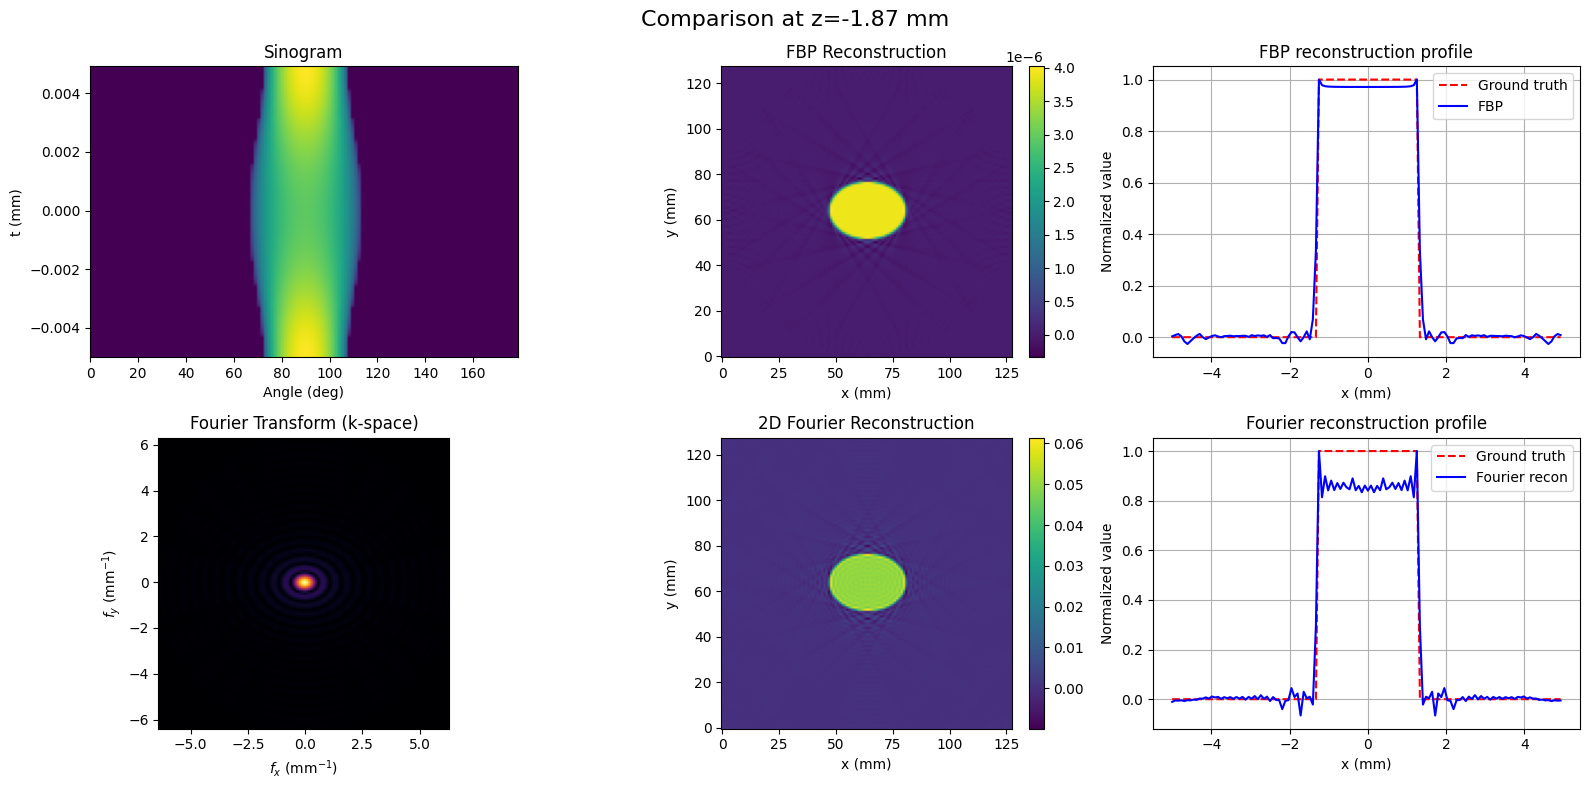

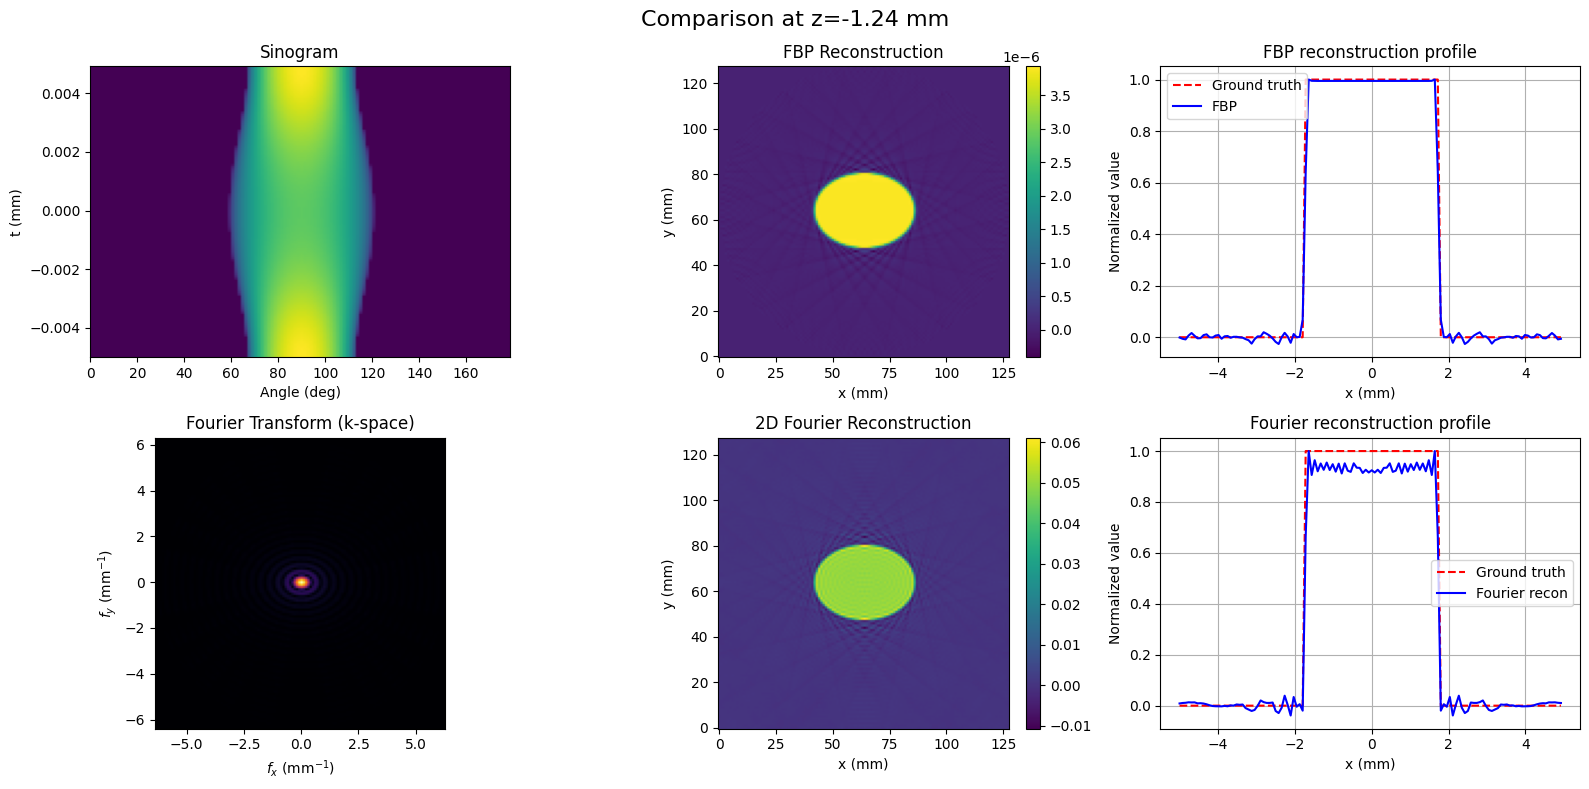

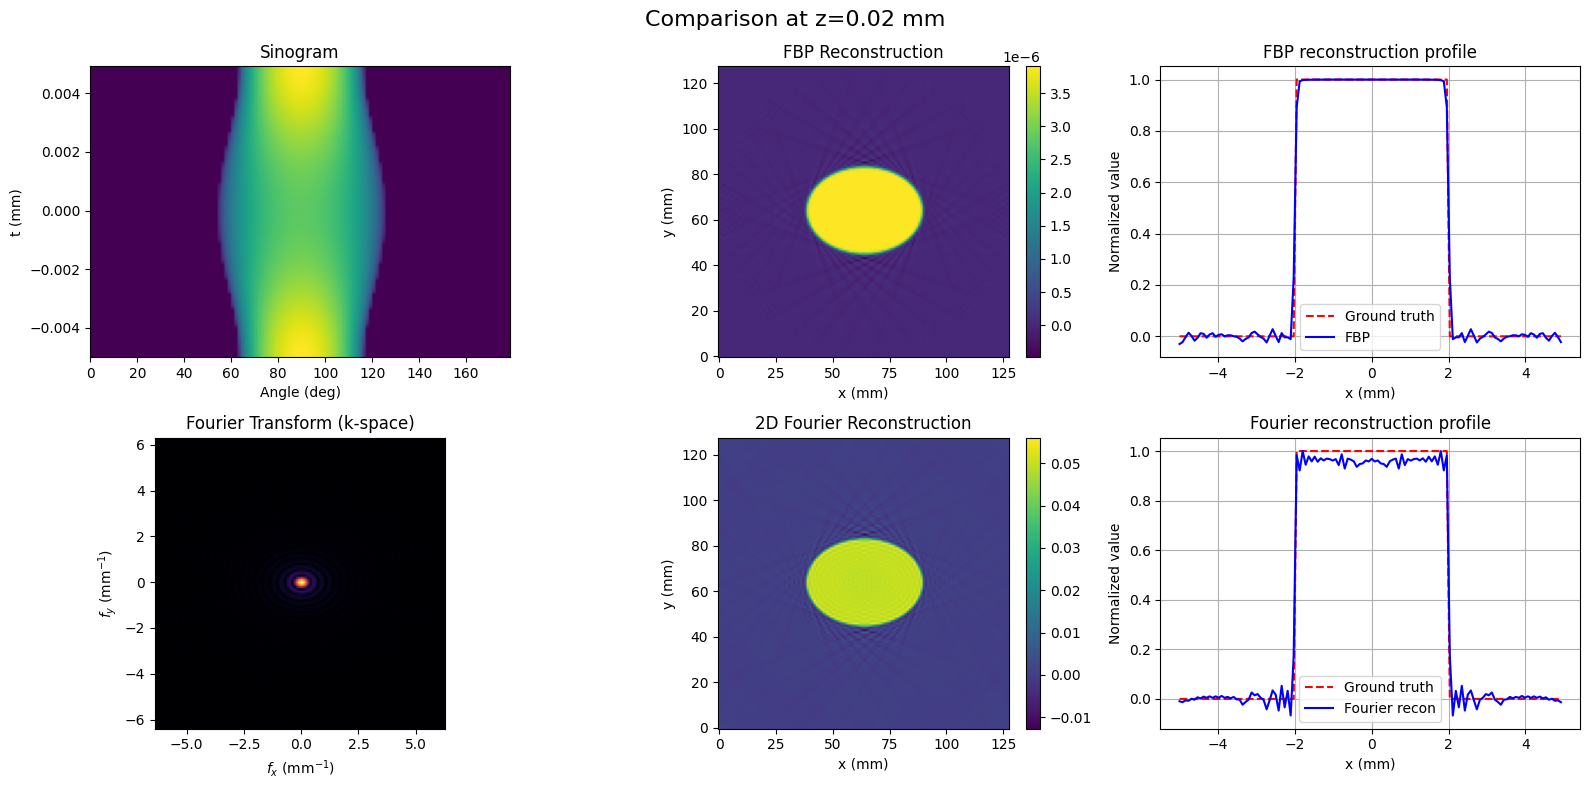

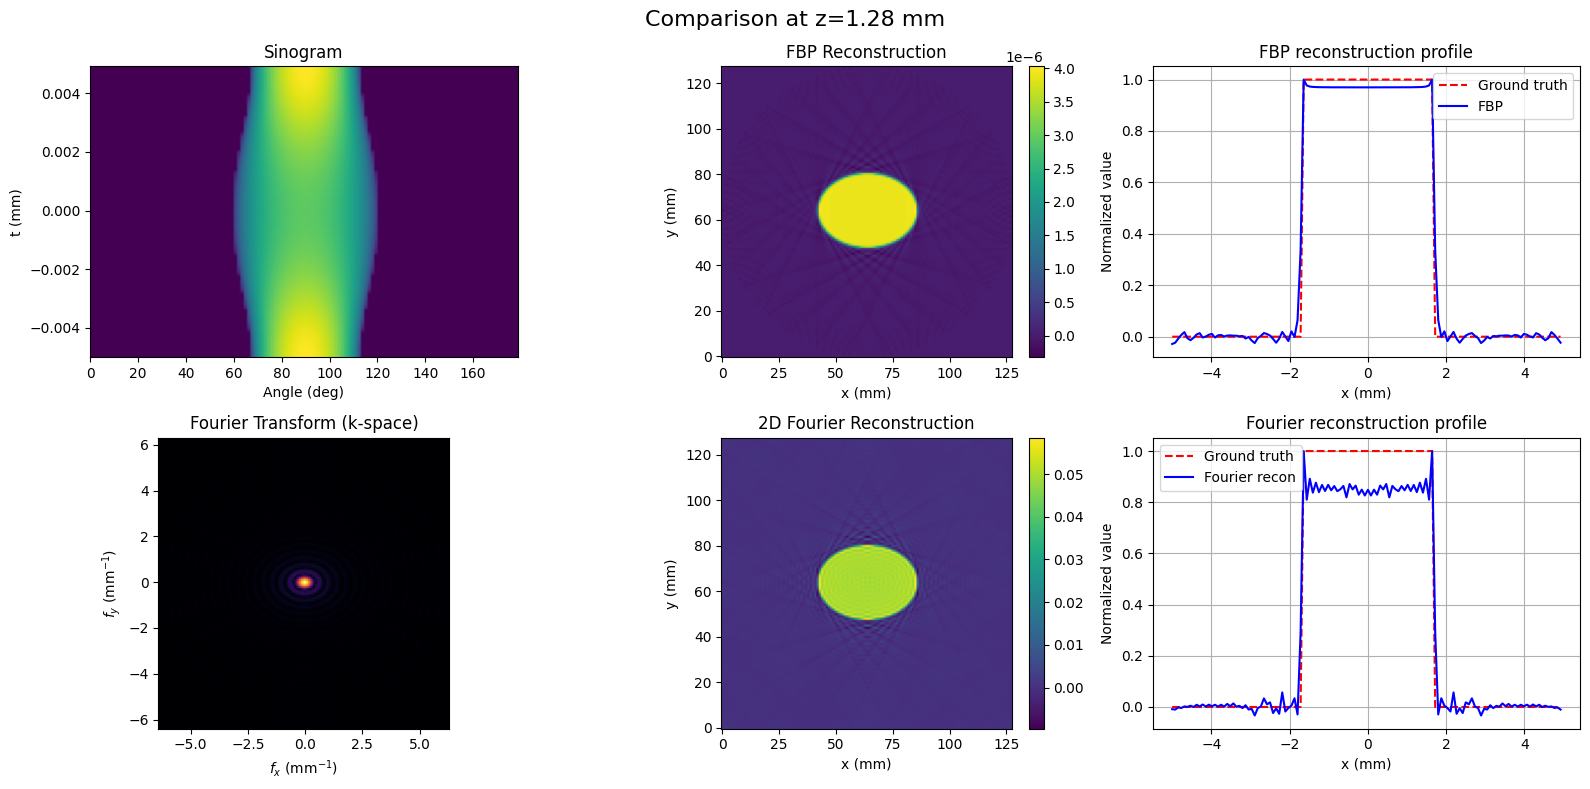

NRMSE for FT interpolation = 0.1356 ± 0.1111
NRMSE for FBP reconstruction = 0.9999 ± 0.0000
SSIM for FT interpolation = 0.8886 ± 0.0415
SSIM for FBP reconstruction = 0.9009 ± 0.0398
reconstruction time with fbp: 1.657s
reconstruction time with FT interpolation: 25.437s


In [11]:
import matplotlib.pyplot as plt
import numpy as np

z_to_show = [N//8, N//4, N//2, 3*N//4]
mid_y = N // 2

# --- Calculate metrics over all slices ---
SSIM_Ft = []
NRMSE_Ft = []
SSIM_fbp = []
NRMSE_fbp = []

for zi in range(N):
    SSIM_Ft.append(structural_similarity(
        object_recon[:, :, zi],
        object3D[:, :, zi],
        data_range=object3D[:, :, zi].max() - object3D[:, :, zi].min()
    ))
    SSIM_fbp.append(structural_similarity(
        recon3D[:, :, zi],
        object3D[:, :, zi],
        data_range=object3D[:, :, zi].max() - object3D[:, :, zi].min()
    ))
    NRMSE_Ft.append(normalized_root_mse(object3D[:, :, zi], object_recon[:, :, zi]))
    NRMSE_fbp.append(normalized_root_mse(object3D[:, :, zi], recon3D[:, :, zi]))

# --- plotting only selected slices ---
for zi in z_to_show:
    fig, axs = plt.subplots(2, 3, figsize=(16, 8))
    ft_profile = object_recon[mid_y, :, zi]
    gt_profile = object3D[mid_y, :, zi]
    fbp_profile = recon3D[mid_y, :, zi]
    fbp_profile = fbp_profile / np.max(np.abs(fbp_profile))
    ft_profile = ft_profile / np.max(np.abs(ft_profile))
    gt_profile = gt_profile / np.max(np.abs(gt_profile))

    # Sinogram
    axs[0, 0].imshow(
       sinogram3D[:, :, zi],
       aspect='auto',
       cmap='viridis',
       extent=[angles[0], angles[-1], y[0], y[-1]]
    )
    axs[0, 0].set_title("Sinogram")
    axs[0, 0].set_xlabel("Angle (deg)")
    axs[0, 0].set_ylabel("t (mm)")

    # FBP reconstruction
    im1 = axs[0, 1].imshow(recon3D[:, :, zi], cmap='viridis', origin='lower')
    axs[0, 1].set_title("FBP Reconstruction")
    axs[0, 1].set_xlabel("x (mm)")
    axs[0, 1].set_ylabel("y (mm)")
    fig.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

    # FBP 1D comparison
    axs[0, 2].plot(x*1e3, gt_profile, 'r--', label='Ground truth')
    axs[0, 2].plot(x*1e3, fbp_profile, 'b-', label='FBP')
    axs[0, 2].set_title("FBP reconstruction profile")
    axs[0, 2].set_xlabel("x (mm)")
    axs[0, 2].set_ylabel("Normalized value")
    axs[0, 2].legend()
    axs[0, 2].grid(True)

    # Fourier transform (k-space coverage)
    axs[1, 0].imshow(
        np.log(np.abs(dataFTcarts[zi]) + 1e-6),
        cmap='inferno',
        origin='lower',
        extent=[fx[0]/1e3, fx[-1]/1e3, fx[0]/1e3, fx[-1]/1e3]
    )
    axs[1, 0].set_title("Fourier Transform (k-space)")
    axs[1, 0].set_xlabel("$f_x$ (mm$^{-1}$)")
    axs[1, 0].set_ylabel("$f_y$ (mm$^{-1}$)")

    # Fourier reconstruction
    im2 = axs[1, 1].imshow(object_recon[:, :, zi], cmap='viridis', origin='lower')
    axs[1, 1].set_title("2D Fourier Reconstruction")
    axs[1, 1].set_xlabel("x (mm)")
    axs[1, 1].set_ylabel("y (mm)")
    fig.colorbar(im2, ax=axs[1, 1], fraction=0.046, pad=0.04)

    # Fourier 1D comparison
    axs[1, 2].plot(x*1e3, gt_profile, 'r--', label='Ground truth')
    axs[1, 2].plot(x*1e3, ft_profile, 'b-', label='Fourier recon')
    axs[1, 2].set_title("Fourier reconstruction profile")
    axs[1, 2].set_xlabel("x (mm)")
    axs[1, 2].set_ylabel("Normalized value")
    axs[1, 2].legend()
    axs[1, 2].grid(True)

    plt.suptitle(f"Comparison at z={z[zi]*1e3:.2f} mm", fontsize=16)
    plt.tight_layout()
    plt.show()

print(f"NRMSE for FT interpolation = {np.mean(NRMSE_Ft):.4f} ± {np.std(NRMSE_Ft):.4f}")
print(f"NRMSE for FBP reconstruction = {np.mean(NRMSE_fbp):.4f} ± {np.std(NRMSE_fbp):.4f}")
print(f"SSIM for FT interpolation = {np.mean(SSIM_Ft):.4f} ± {np.std(SSIM_Ft):.4f}")
print(f"SSIM for FBP reconstruction = {np.mean(SSIM_fbp):.4f} ± {np.std(SSIM_fbp):.4f}")
print(f"reconstruction time with fbp: {fbp_time:.3f}s")      
print(f"reconstruction time with FT interpolation: {FT_recon_time:.3f}s")

We will now test the robustness of both methods to noise, we will add gaussian noise to the projections in order to demonstrate noisy acquisition.  


Processing noise level sigma=0...


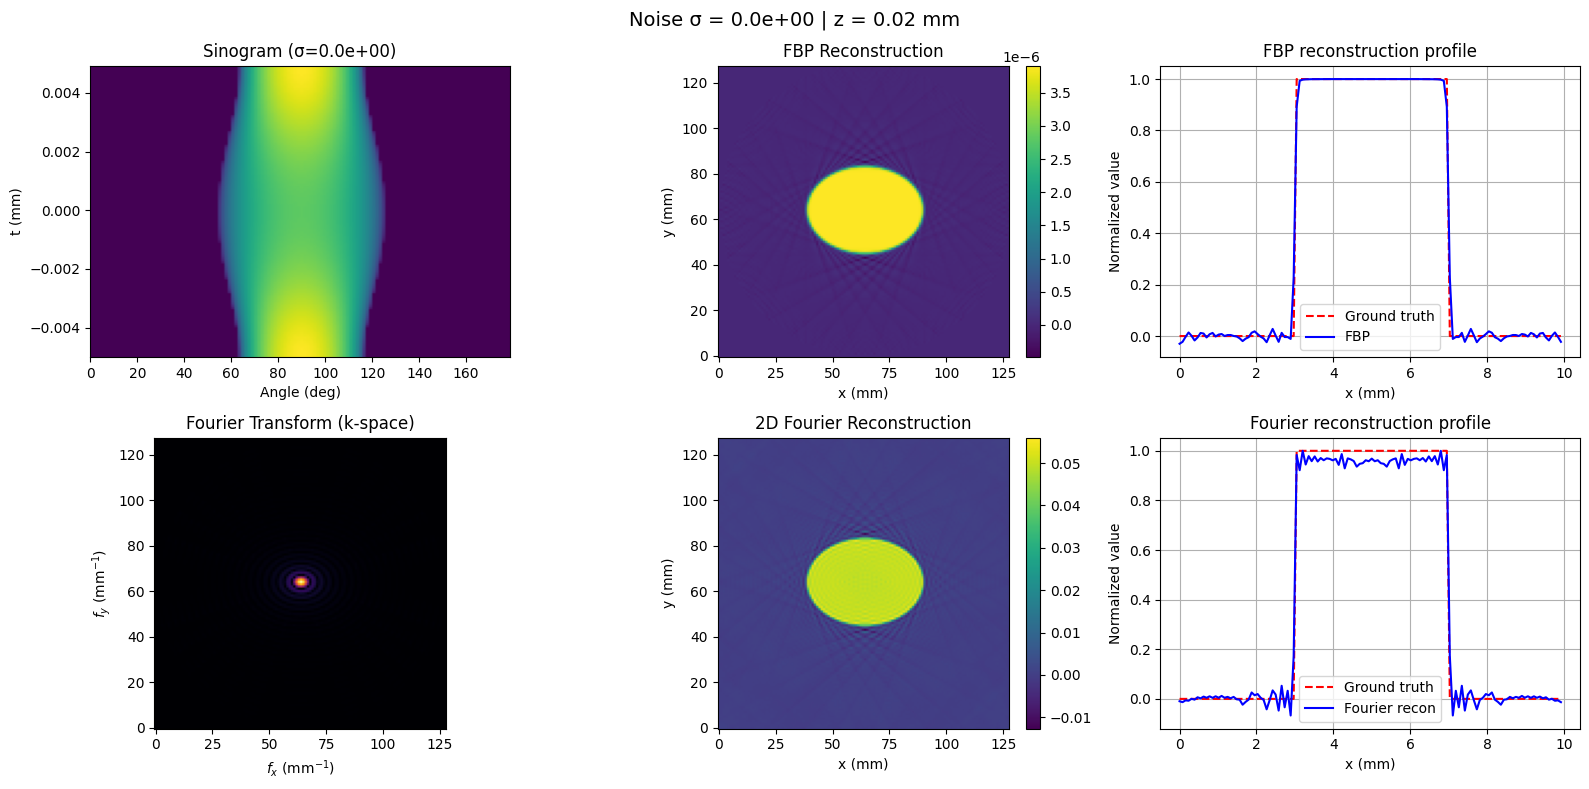


Processing noise level sigma=1e-07...


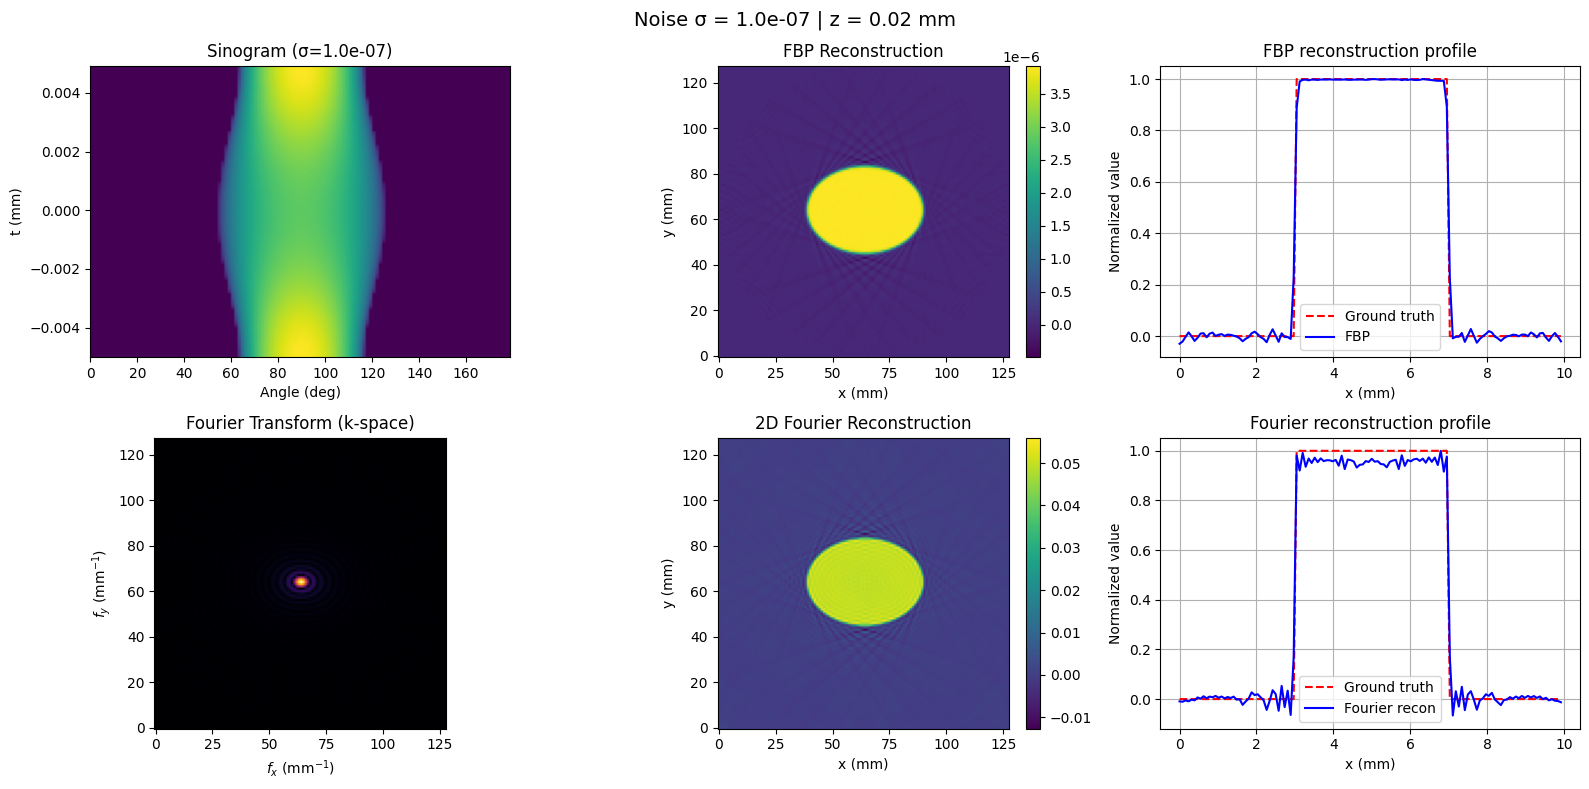


Processing noise level sigma=4e-07...


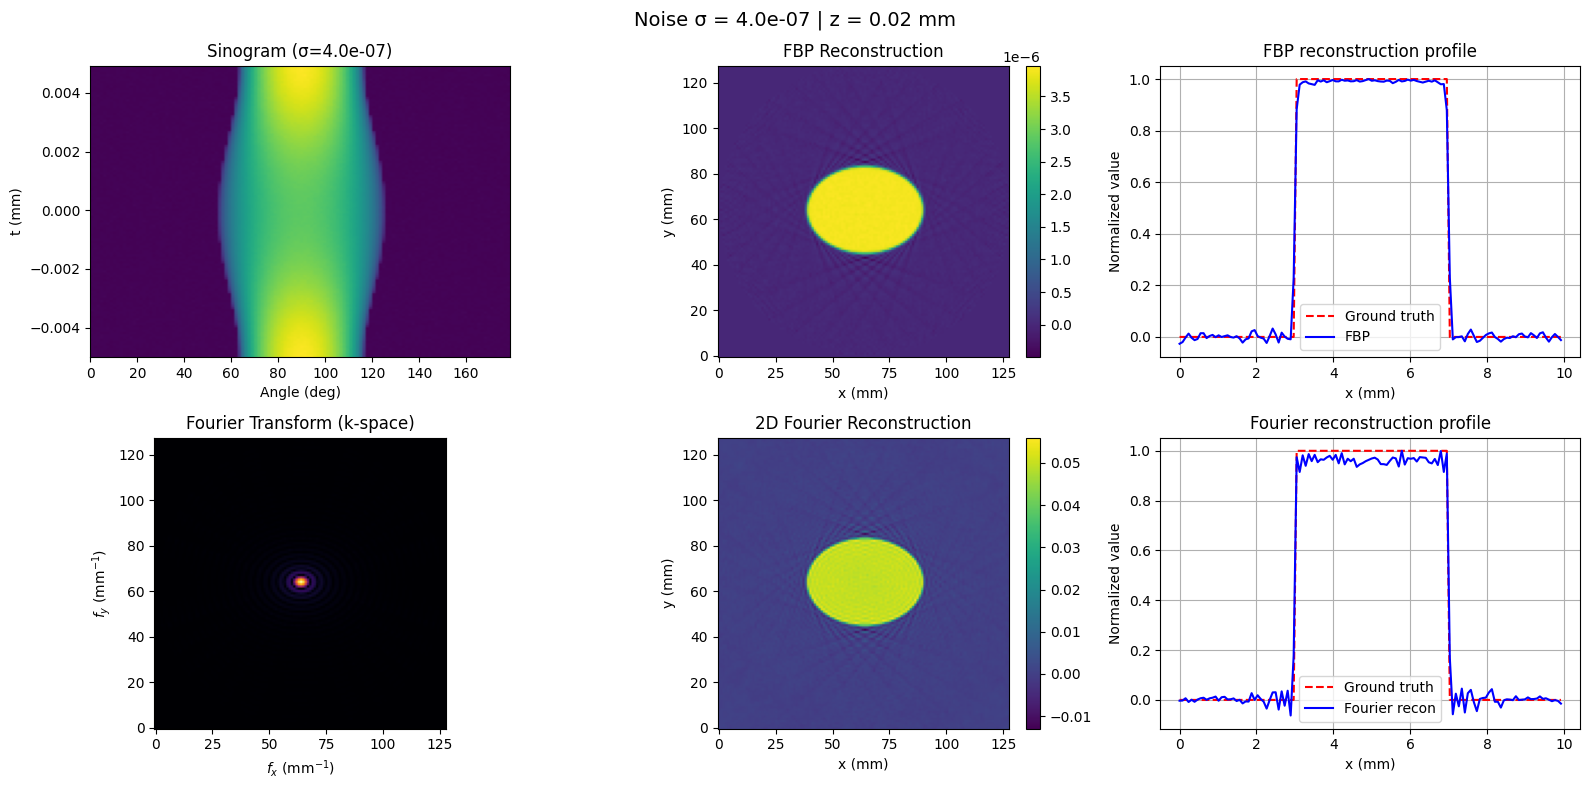


Processing noise level sigma=6e-06...


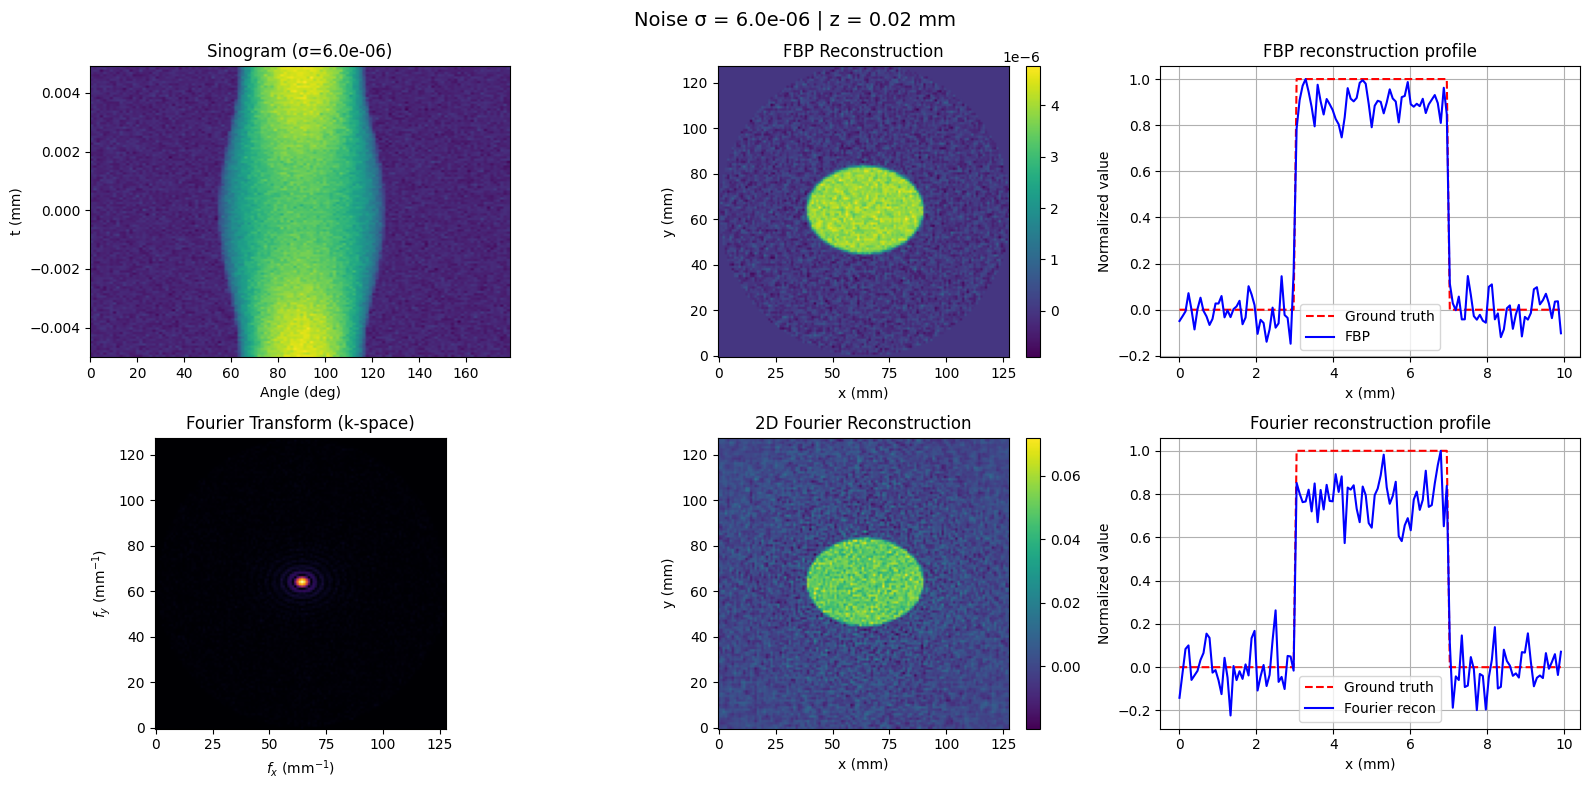


=== Summary of reconstruction metrics ===
Noise(σ)     NRMSE_FBP (mean±std) NRMSE_FT (mean±std)  SSIM_FBP (mean±std)  SSIM_FT (mean±std)   FBP_time(s) FT_time(s)
0.00e+00     0.9999 ± 0.0000      0.1420 ± 0.1307      0.9010 ± 0.0396      0.8895 ± 0.0420      1.648      25.135    
1.00e-07     0.9999 ± 0.0000      0.1426 ± 0.1330      0.9010 ± 0.0396      0.8864 ± 0.0416      1.597      25.182    
4.00e-07     0.9999 ± 0.0000      0.1513 ± 0.1648      0.9010 ± 0.0396      0.8435 ± 0.0368      1.599      25.210    
6.00e-06     0.9999 ± 0.0000      0.6923 ± 1.5631      0.9010 ± 0.0396      0.0949 ± 0.0762      1.647      25.430    


In [15]:
# --- Prepare summary storage ---
summary_metrics = []

noise_levels = [0, 0.1e-6, 0.4e-6, 0.6e-6]
for sigma in noise_levels:

    print(f"\nProcessing noise level sigma={sigma}...")

    # --- Add noise to projections ---
    noisy_projections = additive_noise(projections_2D, sigma, enabled=True)
    sinogram3D = noisy_projections.copy()

    # --- Reconstruct ---
    recon3D, fbp_time = fbp_reconstruct(sinogram3D, angles, nproj, z, y)
    object_recon, FT_recon_time, datafx, datafy, dataFTcarts = ft_interpolation_reconstruct(
        noisy_projections, angles, nproj, y, z, object3D, deltax
    )

    # --- Initialize metric lists ---
    SSIM_Ft = []
    NRMSE_Ft = []
    SSIM_fbp = []
    NRMSE_fbp = []

    # --- Dimensions and x axis for profiles (safety) ---
    Nx = object3D.shape[1] if object3D.ndim == 3 else object3D.shape[0]
    # NOTE: depending on your object3D layout Nx/Ny may differ; this replicates your earlier setup:
    Nx = object3D.shape[1]  # x length (used for x in profile)
    Ny = object3D.shape[0]  # y length (used as mid index)
    Nz = object3D.shape[2]
    x = np.linspace(0, deltax * (Nx - 1), Nx)

    # --- Calculate metrics over all slices ---
    for zi in range(Nz):
        SSIM_Ft.append(structural_similarity(
            object_recon[:, :, zi],
            object3D[:, :, zi],
            data_range=object3D[:, :, zi].max() - object3D[:, :, zi].min()
        ))
        SSIM_fbp.append(structural_similarity(
            recon3D[:, :, zi],
            object3D[:, :, zi],
            data_range=object3D[:, :, zi].max() - object3D[:, :, zi].min()
        ))
        NRMSE_Ft.append(normalized_root_mse(object3D[:, :, zi], object_recon[:, :, zi]))
        NRMSE_fbp.append(normalized_root_mse(object3D[:, :, zi], recon3D[:, :, zi]))

    # --- Visualization for mid slice ---
    mid_z = Nz // 2
    mid_y = object3D.shape[0] // 2  # matches object_recon[mid_y, :, zi] indexing in your working code

    fig, axs = plt.subplots(2, 3, figsize=(16, 8))
    gt_slice = object3D[:, :, mid_z]
    fbp_slice = recon3D[:, :, mid_z]
    ft_slice = object_recon[:, :, mid_z]

    # 1D profiles across x (same as your working code)
    gt_profile = gt_slice[mid_y, :]
    fbp_profile = fbp_slice[mid_y, :]
    ft_profile = ft_slice[mid_y, :]

    # Normalize profiles (avoid divide by zero)
    if np.max(np.abs(gt_profile)) != 0:
        gt_profile = gt_profile / np.max(np.abs(gt_profile))
    if np.max(np.abs(fbp_profile)) != 0:
        fbp_profile = fbp_profile / np.max(np.abs(fbp_profile))
    if np.max(np.abs(ft_profile)) != 0:
        ft_profile = ft_profile / np.max(np.abs(ft_profile))

    # --- Sinogram ---
    axs[0, 0].imshow(
        sinogram3D[:, :, mid_z],
        aspect='auto', cmap='viridis',
        extent=[angles[0], angles[-1], y[0], y[-1]]
    )
    axs[0, 0].set_title(f"Sinogram (σ={sigma:.1e})")
    axs[0, 0].set_xlabel("Angle (deg)")
    axs[0, 0].set_ylabel("t (mm)")

    # --- FBP Reconstruction ---
    im1 = axs[0, 1].imshow(fbp_slice, cmap='viridis', origin='lower')
    axs[0, 1].set_title("FBP Reconstruction")
    axs[0, 1].set_xlabel("x (mm)")
    axs[0, 1].set_ylabel("y (mm)")
    fig.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

    # --- FBP 1D Profile ---
    axs[0, 2].plot(x * 1e3, gt_profile, 'r--', label='Ground truth')
    axs[0, 2].plot(x * 1e3, fbp_profile, 'b-', label='FBP')
    axs[0, 2].set_title("FBP reconstruction profile")
    axs[0, 2].set_xlabel("x (mm)")
    axs[0, 2].set_ylabel("Normalized value")
    axs[0, 2].legend()
    axs[0, 2].grid(True)

    # --- Fourier transform (k-space coverage) ---
    # show k-space magnitude (log) for this slice; extent omitted to avoid shape mismatch
    axs[1, 0].imshow(
        np.log(np.abs(dataFTcarts[mid_z]) + 1e-6),
        cmap='inferno',
        origin='lower'
    )
    axs[1, 0].set_title("Fourier Transform (k-space)")
    axs[1, 0].set_xlabel("$f_x$ (mm$^{-1}$)")
    axs[1, 0].set_ylabel("$f_y$ (mm$^{-1}$)")

    # --- Fourier reconstruction ---
    im2 = axs[1, 1].imshow(ft_slice, cmap='viridis', origin='lower')
    axs[1, 1].set_title("2D Fourier Reconstruction")
    axs[1, 1].set_xlabel("x (mm)")
    axs[1, 1].set_ylabel("y (mm)")
    fig.colorbar(im2, ax=axs[1, 1], fraction=0.046, pad=0.04)

    # --- Fourier 1D comparison ---
    axs[1, 2].plot(x * 1e3, gt_profile, 'r--', label='Ground truth')
    axs[1, 2].plot(x * 1e3, ft_profile, 'b-', label='Fourier recon')
    axs[1, 2].set_title("Fourier reconstruction profile")
    axs[1, 2].set_xlabel("x (mm)")
    axs[1, 2].set_ylabel("Normalized value")
    axs[1, 2].legend()
    axs[1, 2].grid(True)

    plt.suptitle(f"Noise σ = {sigma:.1e} | z = {z[mid_z]*1e3:.2f} mm", fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- Store metrics ---
    summary_metrics.append({
        "sigma": sigma,
        "NRMSE_FBP_mean": np.mean(NRMSE_fbp),
        "NRMSE_FBP_std": np.std(NRMSE_fbp),
        "NRMSE_FT_mean": np.mean(NRMSE_Ft),
        "NRMSE_FT_std": np.std(NRMSE_Ft),
        "SSIM_FBP_mean": np.mean(SSIM_fbp),
        "SSIM_FBP_std": np.std(SSIM_fbp),
        "SSIM_FT_mean": np.mean(SSIM_Ft),
        "SSIM_FT_std": np.std(SSIM_Ft),
        "FBP_time": fbp_time,
        "FT_time": FT_recon_time
    })

# --- Print summary table ---
print("\n=== Summary of reconstruction metrics ===")
header = ("Noise(σ)", "NRMSE_FBP (mean±std)", "NRMSE_FT (mean±std)",
          "SSIM_FBP (mean±std)", "SSIM_FT (mean±std)", "FBP_time(s)", "FT_time(s)")
print("{:<12} {:<20} {:<20} {:<20} {:<20} {:<10} {:<10}".format(*header))

for m in summary_metrics:
    print("{:<12.2e} {:<20} {:<20} {:<20} {:<20} {:<10.3f} {:<10.3f}".format(
        m["sigma"],
        f"{m['NRMSE_FBP_mean']:.4f} ± {m['NRMSE_FBP_std']:.4f}",
        f"{m['NRMSE_FT_mean']:.4f} ± {m['NRMSE_FT_std']:.4f}",
        f"{m['SSIM_FBP_mean']:.4f} ± {m['SSIM_FBP_std']:.4f}",
        f"{m['SSIM_FT_mean']:.4f} ± {m['SSIM_FT_std']:.4f}",
        m["FBP_time"],
        m["FT_time"]
    ))


In [ ]:
summary_metrics = []
n_proj_list = [128, 180, 360, 500]

for nproj in n_proj_list:
    angles = np.linspace(0, 180, nproj, endpoint=False)  # redefine angles for current nproj
    print(f"\n=== Processing {nproj} projections ===")

    # --- Create projections ---
    projections_2D, projections_2D_FT, sinogram3D, angles = create_projections(nproj)
    sinogram3D = projections_2D.copy()

    # --- Reconstruct ---
    recon3D, fbp_time = fbp_reconstruct(sinogram3D, angles, nproj, z, y)
    object_recon, FT_recon_time, datafx, datafy, dataFTcarts = ft_interpolation_reconstruct(
        projections_2D, angles, nproj, y, z, object3D, deltax
    )

    # --- Initialize metric lists ---
    SSIM_Ft, NRMSE_Ft, SSIM_fbp, NRMSE_fbp = [], [], [], []
    Nz = object3D.shape[2]

    # --- Calculate metrics per slice ---
    for zi in range(Nz):
        SSIM_Ft.append(structural_similarity(
            object_recon[:, :, zi],
            object3D[:, :, zi],
            data_range=object3D[:, :, zi].max() - object3D[:, :, zi].min()
        ))
        SSIM_fbp.append(structural_similarity(
            recon3D[:, :, zi],
            object3D[:, :, zi],
            data_range=object3D[:, :, zi].max() - object3D[:, :, zi].min()
        ))
        NRMSE_Ft.append(normalized_root_mse(object3D[:, :, zi], object_recon[:, :, zi]))
        NRMSE_fbp.append(normalized_root_mse(object3D[:, :, zi], recon3D[:, :, zi]))

    # --- Store metrics ---
    summary_metrics.append({
        "nproj": nproj,
        "NRMSE_FBP_mean": np.mean(NRMSE_fbp),
        "NRMSE_FBP_std": np.std(NRMSE_fbp),
        "NRMSE_FT_mean": np.mean(NRMSE_Ft),
        "NRMSE_FT_std": np.std(NRMSE_Ft),
        "SSIM_FBP_mean": np.mean(SSIM_fbp),
        "SSIM_FBP_std": np.std(SSIM_fbp),
        "SSIM_FT_mean": np.mean(SSIM_Ft),
        "SSIM_FT_std": np.std(SSIM_Ft),
        "FBP_time": fbp_time,
        "FT_time": FT_recon_time
    })

# --- Print summary ---
print("\n=== Summary of reconstruction metrics ===")
header = ("Projections", "NRMSE_FBP (mean±std)", "NRMSE_FT (mean±std)", 
          "SSIM_FBP (mean±std)", "SSIM_FT (mean±std)", "FBP_time(s)", "FT_time(s)")
print("{:<12} {:<20} {:<20} {:<20} {:<20} {:<10} {:<10}".format(*header))

for m in summary_metrics:
    print("{:<12d} {:<20} {:<20} {:<20} {:<20} {:<10.3f} {:<10.3f}".format(
        m["nproj"],
        f"{m['NRMSE_FBP_mean']:.4f} ± {m['NRMSE_FBP_std']:.4f}",
        f"{m['NRMSE_FT_mean']:.4f} ± {m['NRMSE_FT_std']:.4f}",
        f"{m['SSIM_FBP_mean']:.4f} ± {m['SSIM_FBP_std']:.4f}",
        f"{m['SSIM_FT_mean']:.4f} ± {m['SSIM_FT_std']:.4f}",
        m["FBP_time"],
        m["FT_time"]
    ))


we'll compare now how different filters for FBP deal with different noise levels


Processing noise level sigma=0...
  → Reconstructing with ramp filter


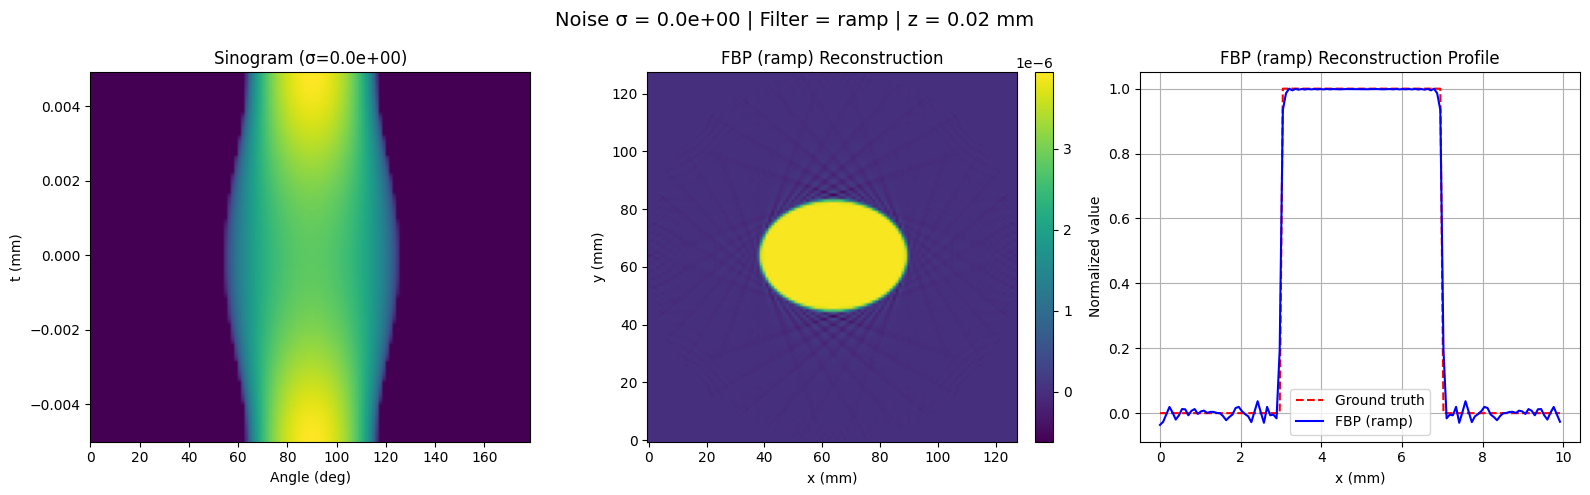

  → Reconstructing with shepp-logan filter


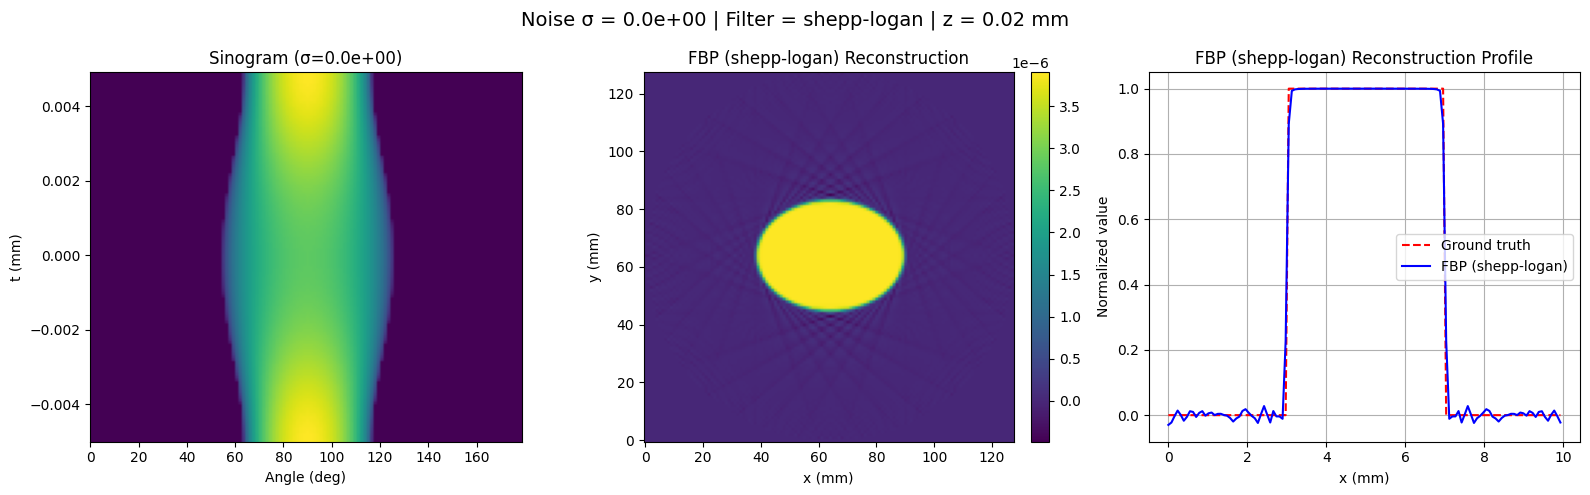

  → Reconstructing with cosine filter


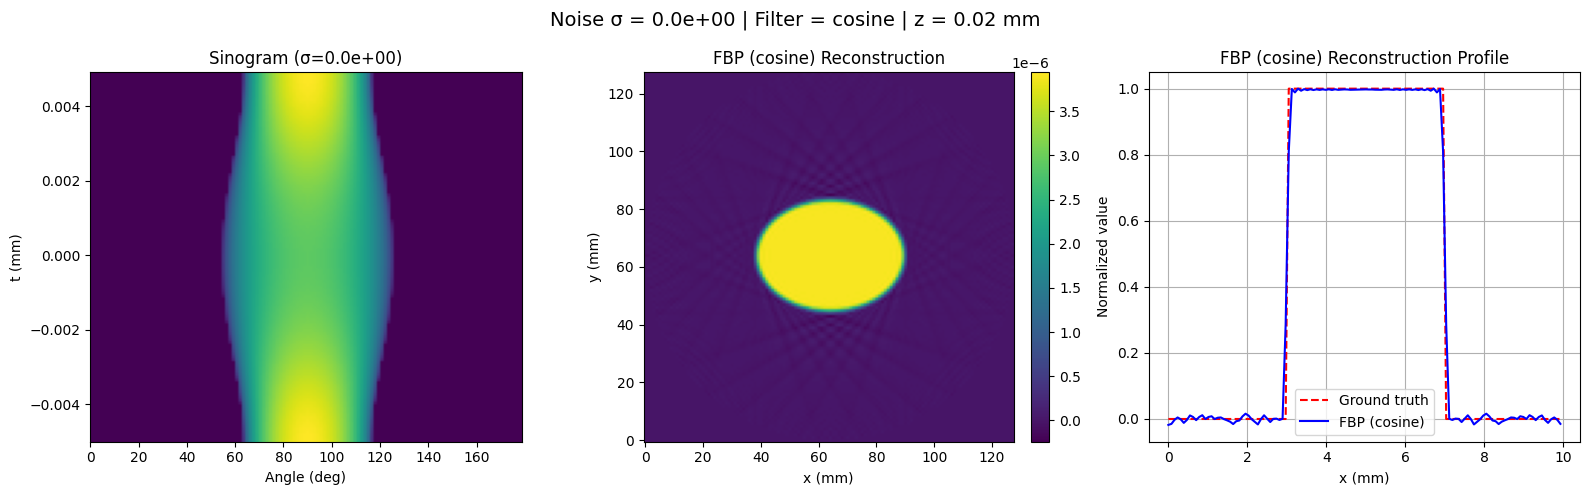

  → Reconstructing with hamming filter


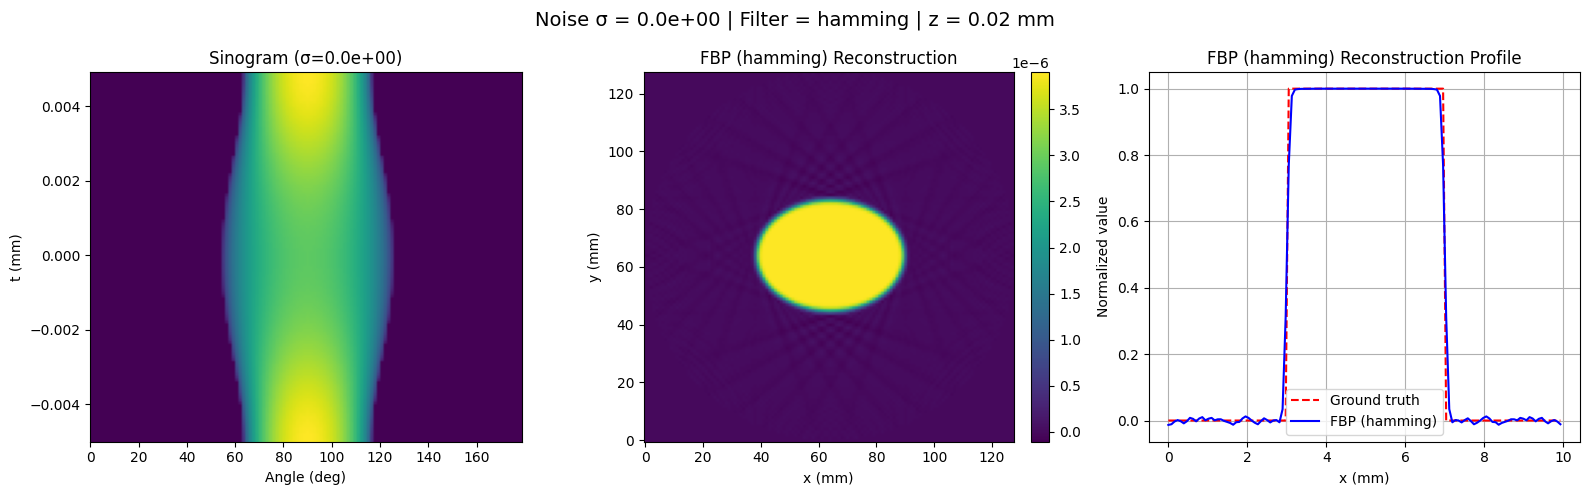

  → Reconstructing with hann filter


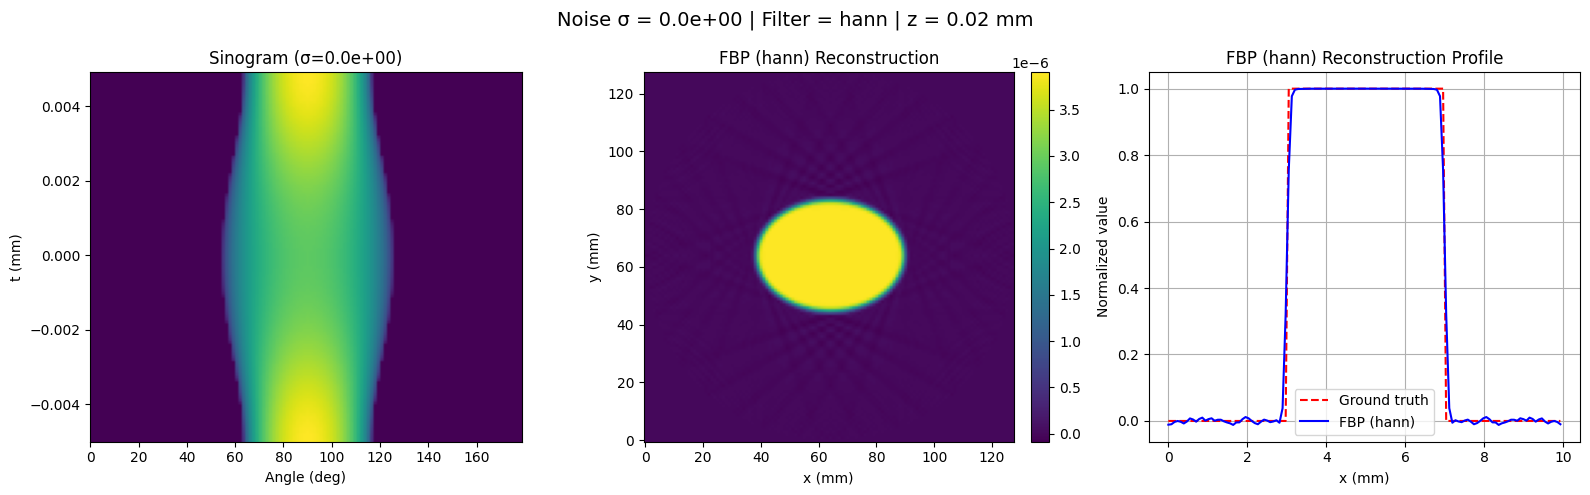


Processing noise level sigma=1e-07...
  → Reconstructing with ramp filter


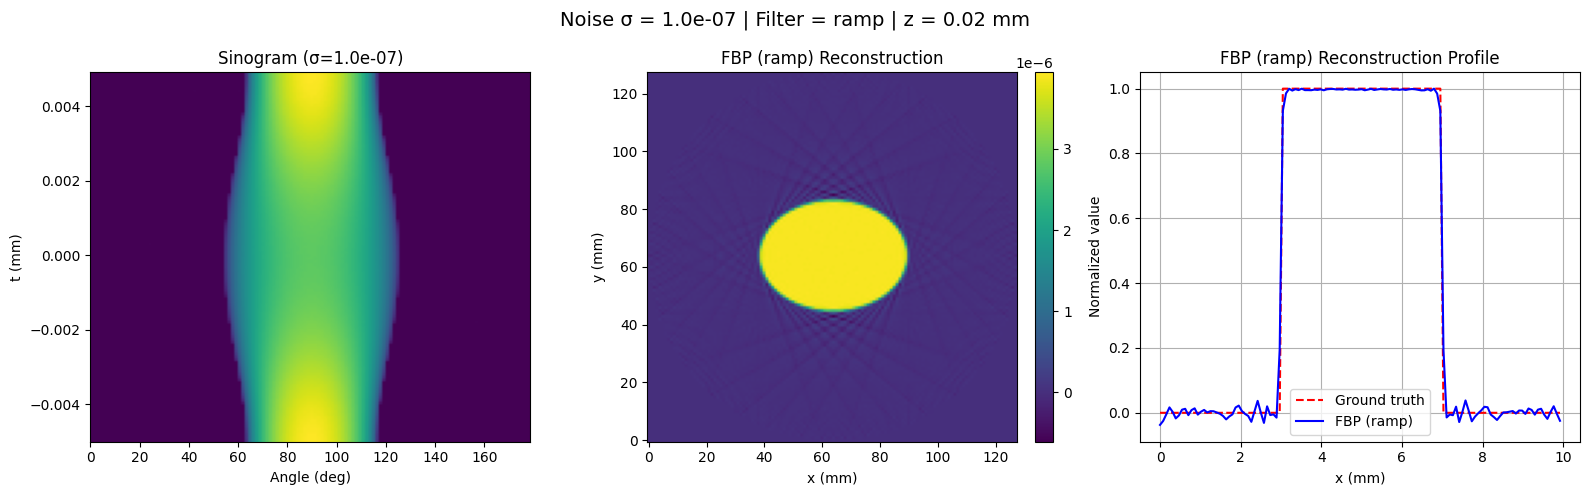

  → Reconstructing with shepp-logan filter


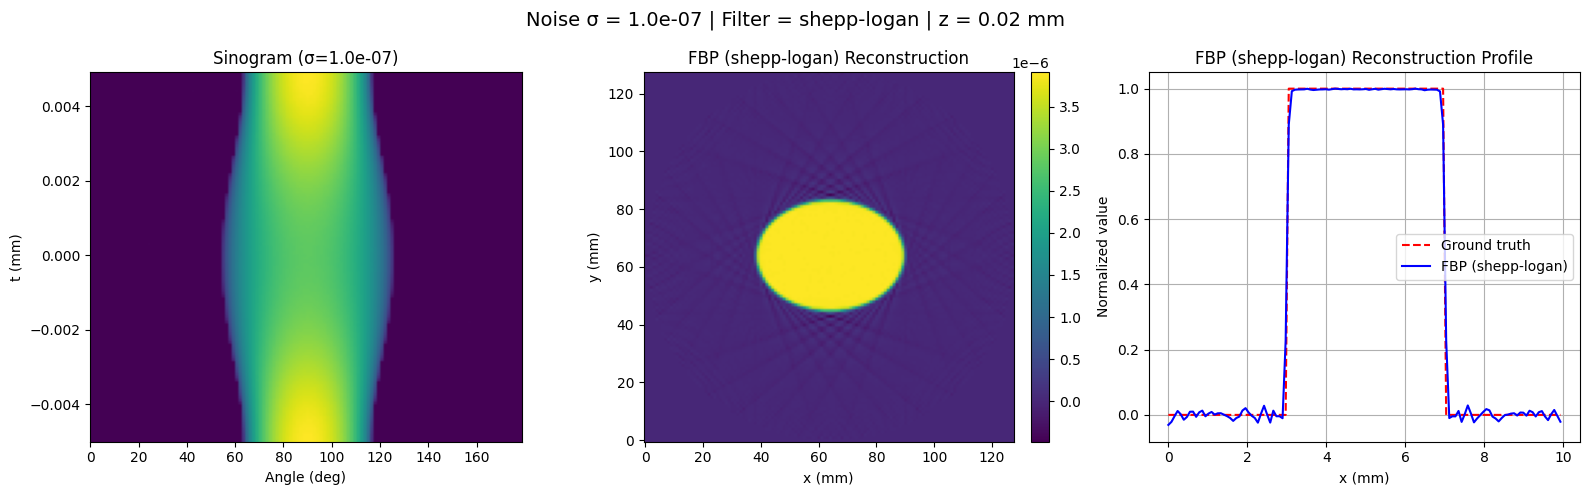

  → Reconstructing with cosine filter


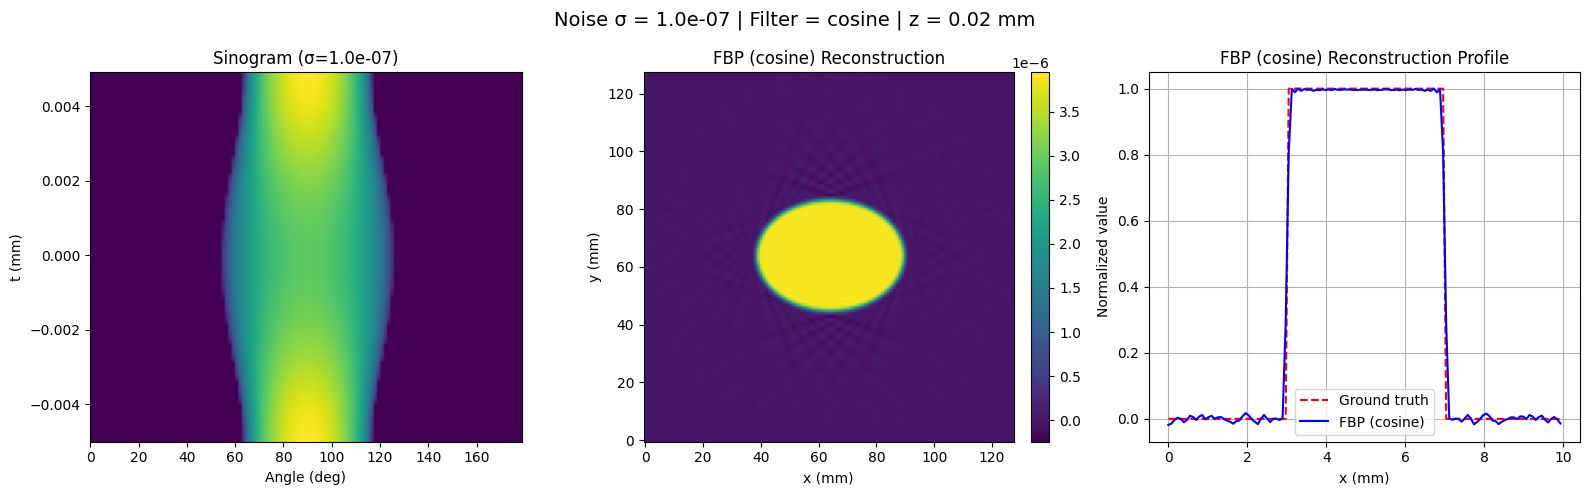

  → Reconstructing with hamming filter


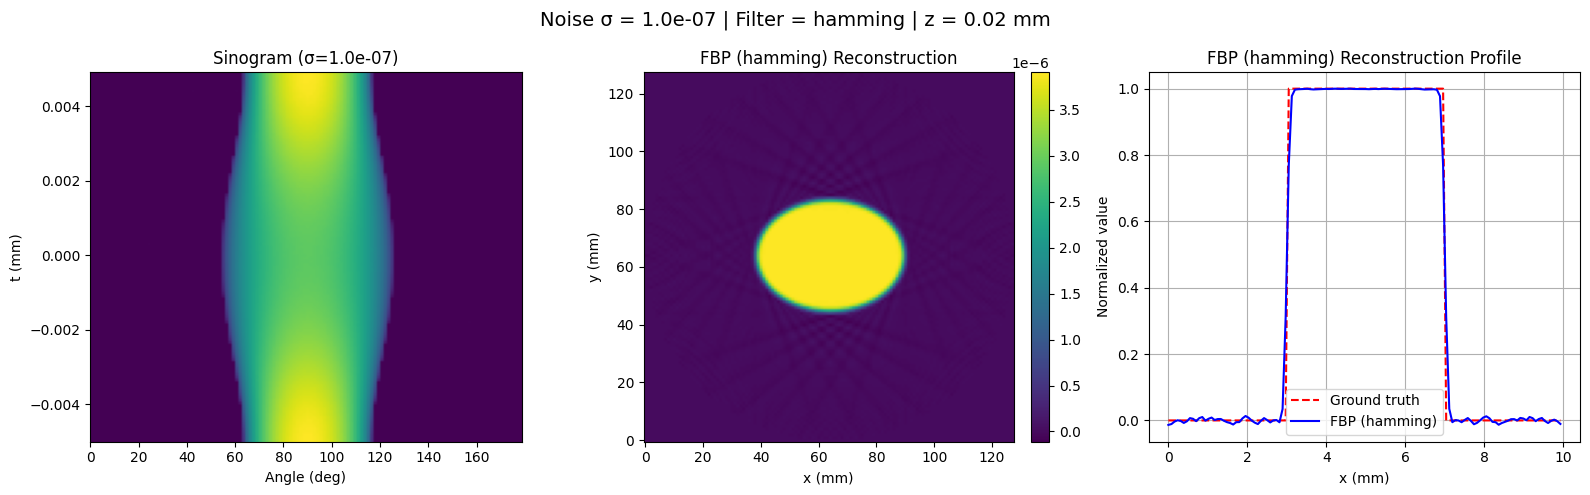

  → Reconstructing with hann filter


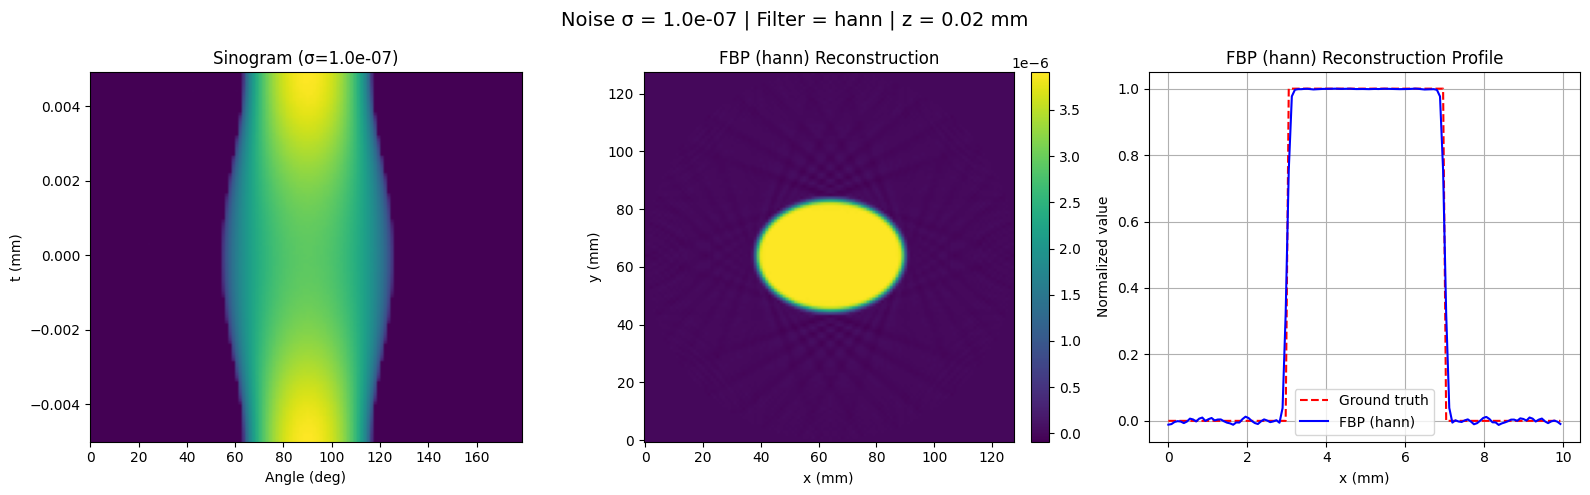


Processing noise level sigma=4e-07...
  → Reconstructing with ramp filter


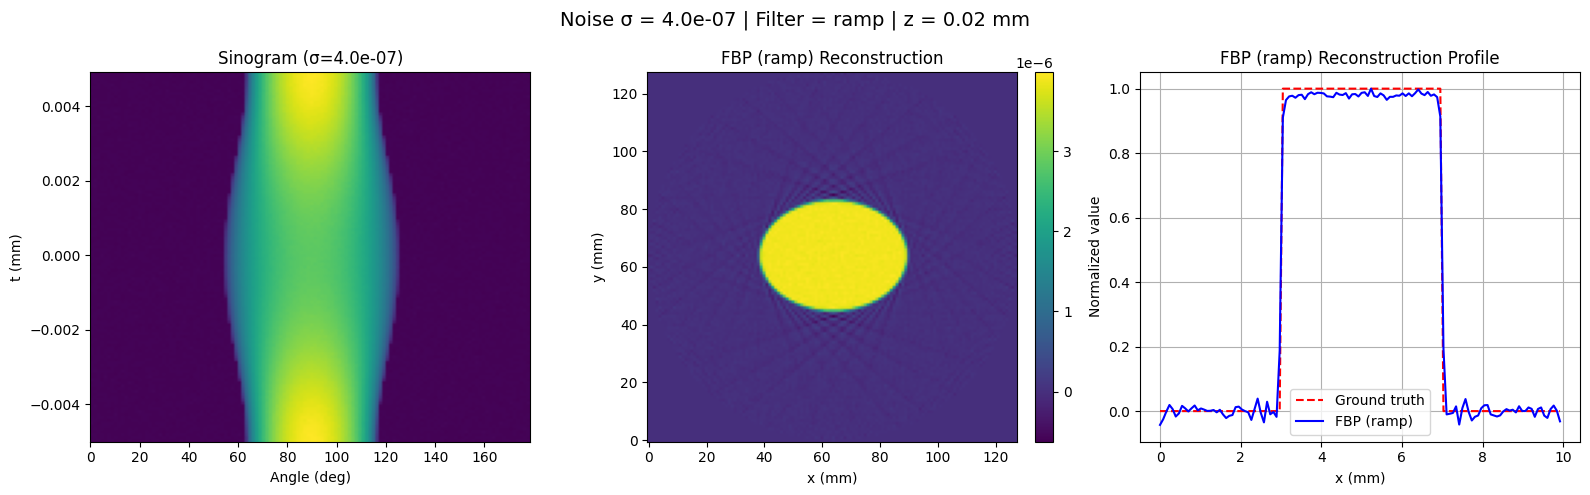

  → Reconstructing with shepp-logan filter


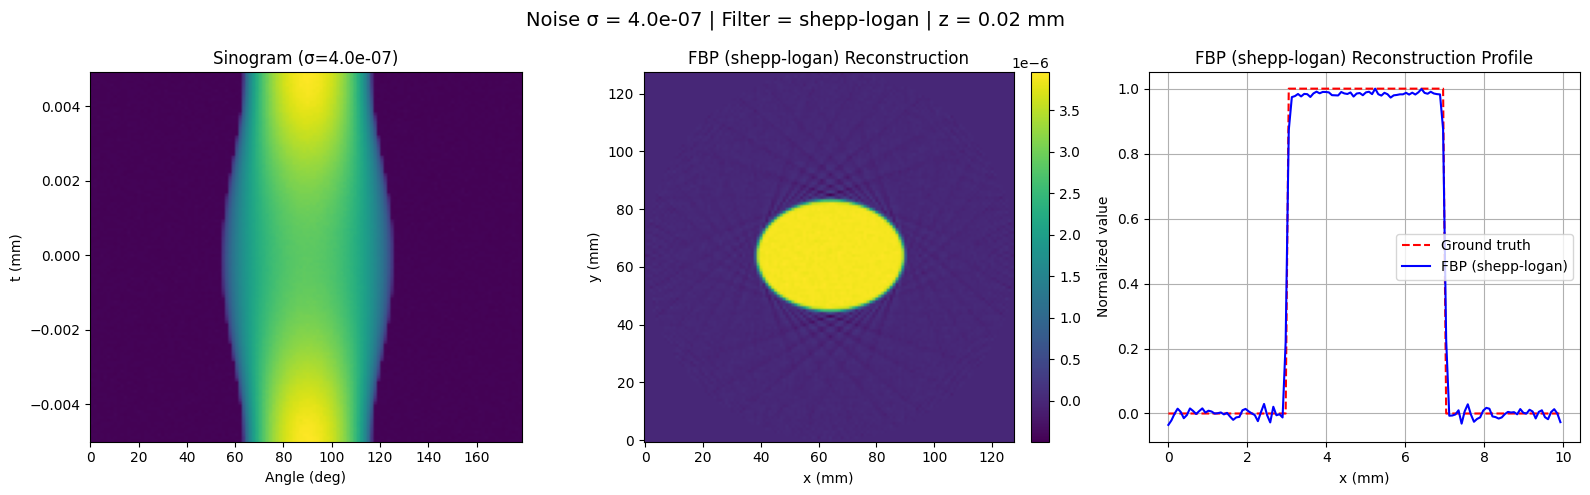

  → Reconstructing with cosine filter


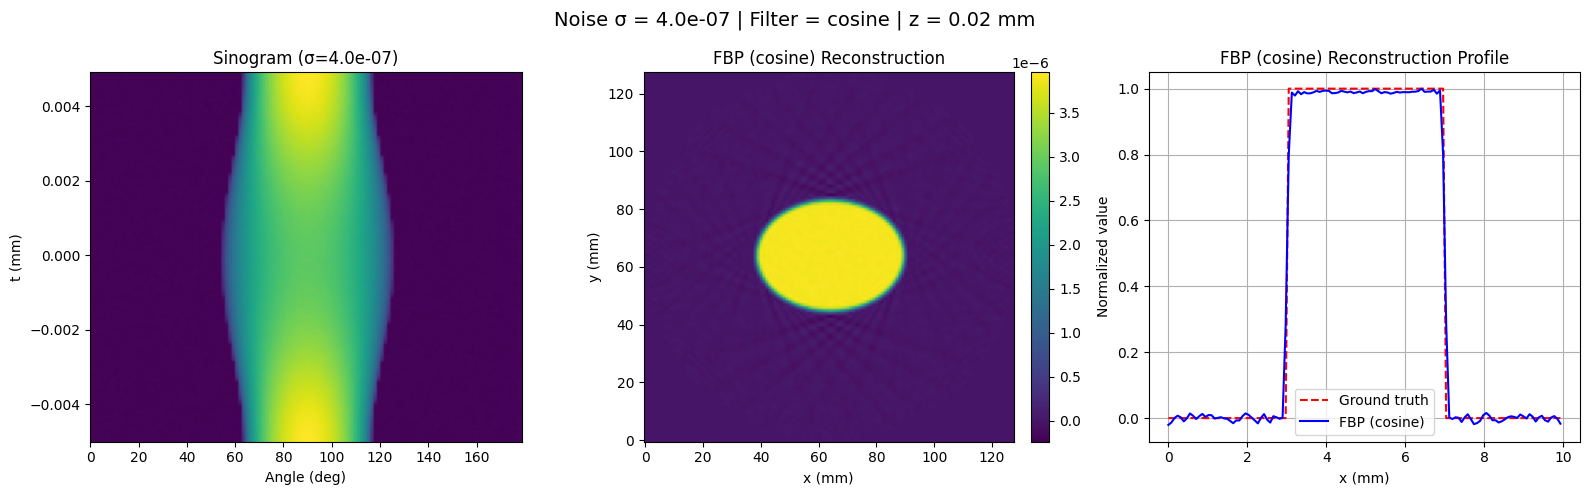

  → Reconstructing with hamming filter


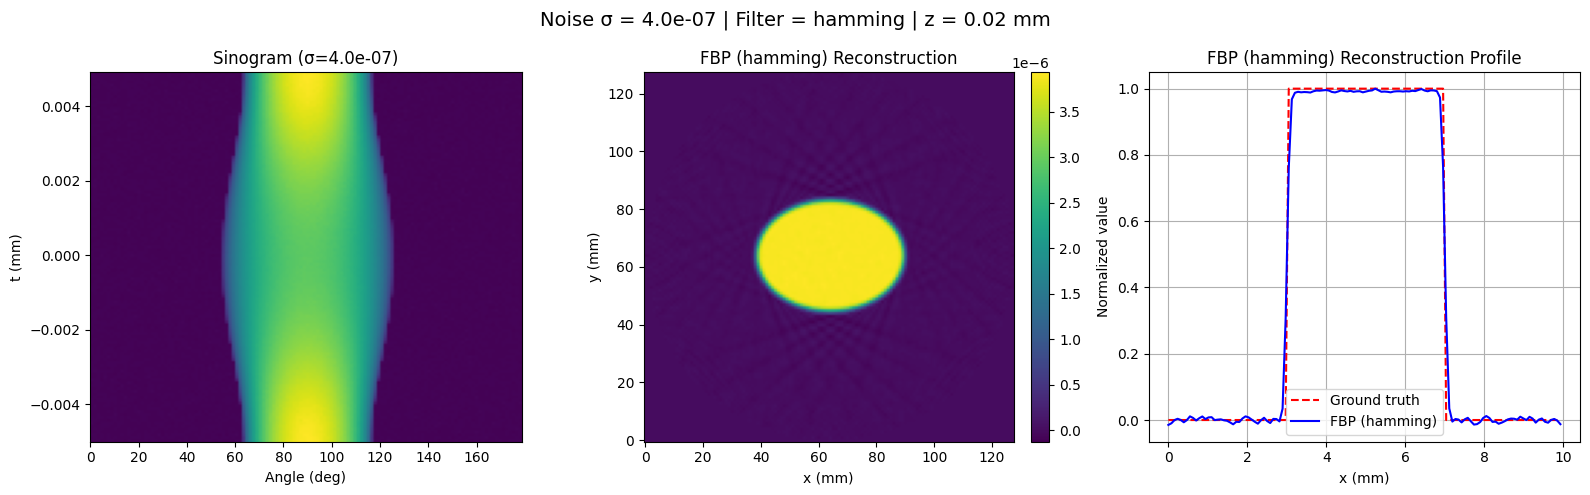

  → Reconstructing with hann filter


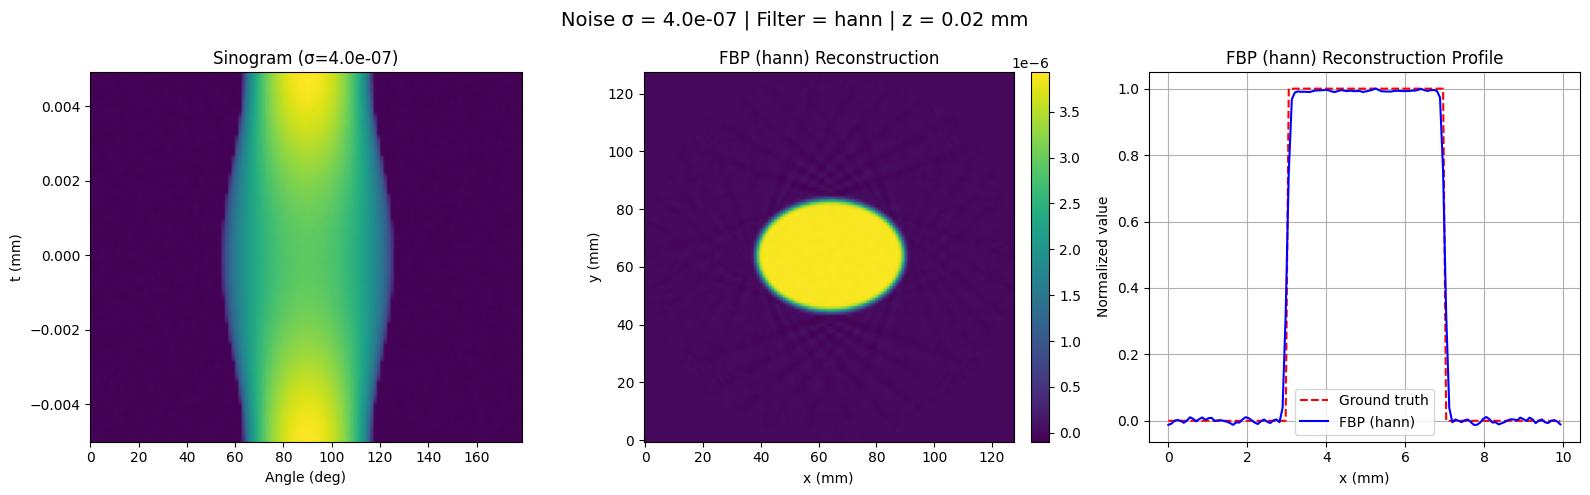


Processing noise level sigma=6e-07...
  → Reconstructing with ramp filter


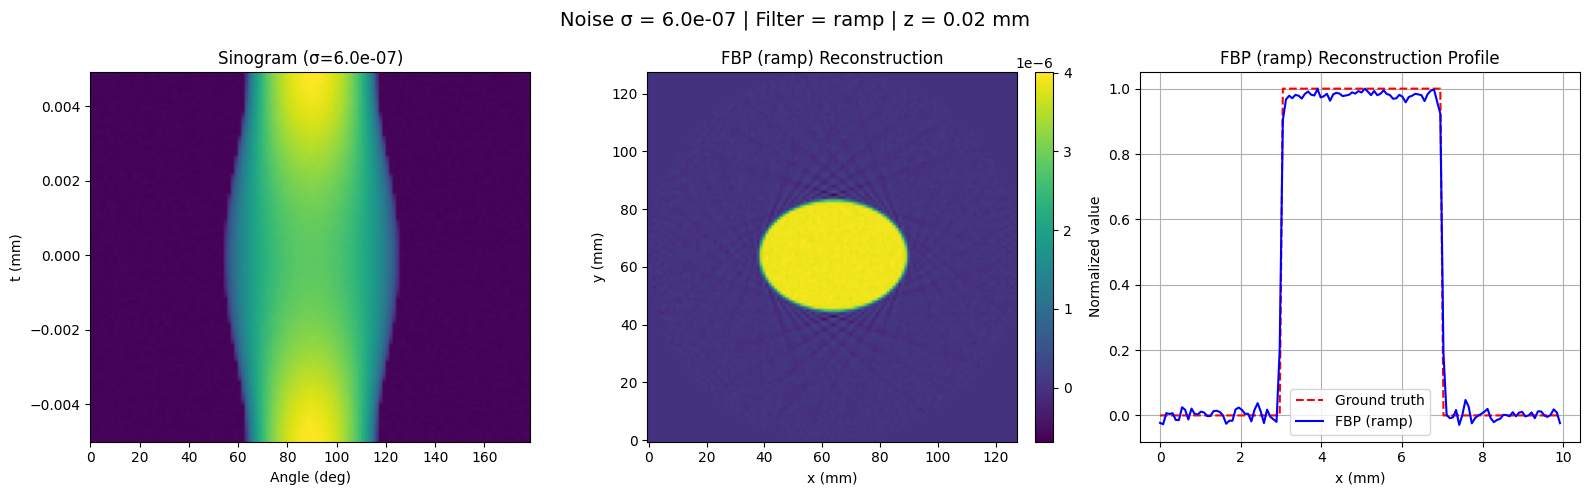

  → Reconstructing with shepp-logan filter


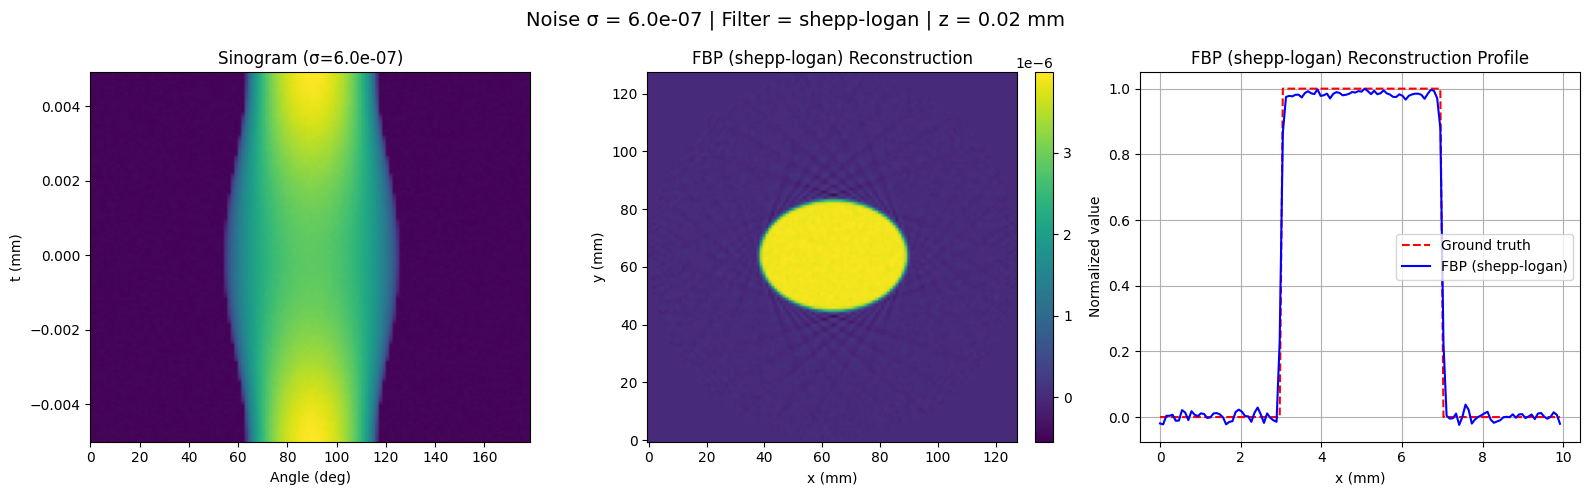

  → Reconstructing with cosine filter


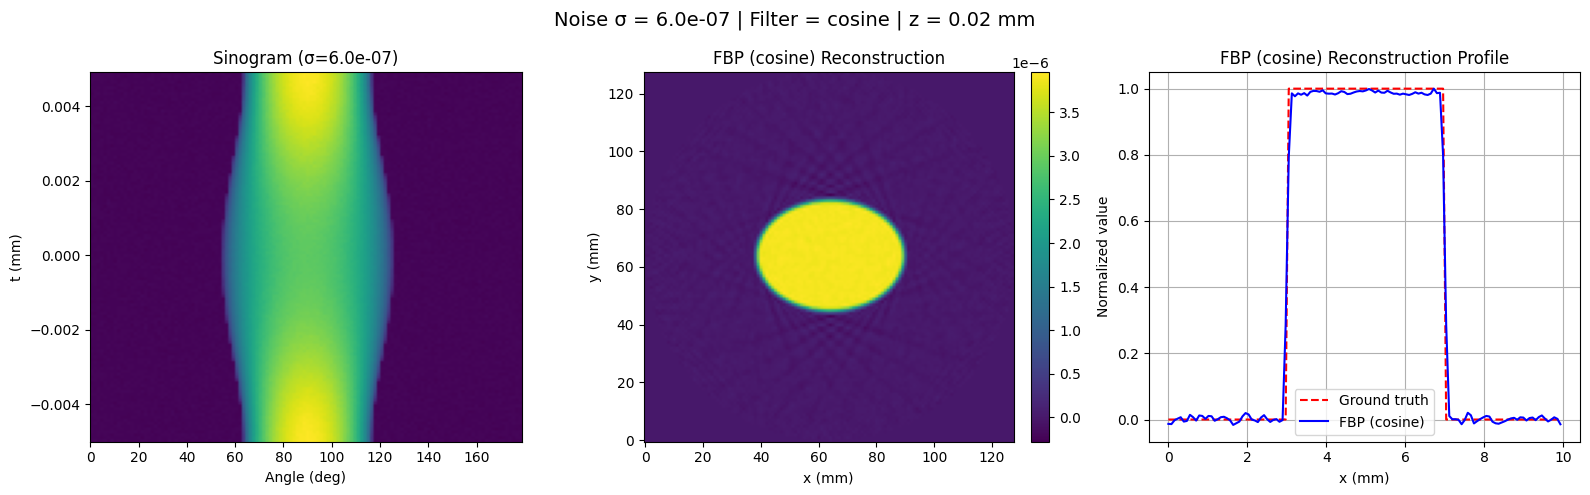

  → Reconstructing with hamming filter


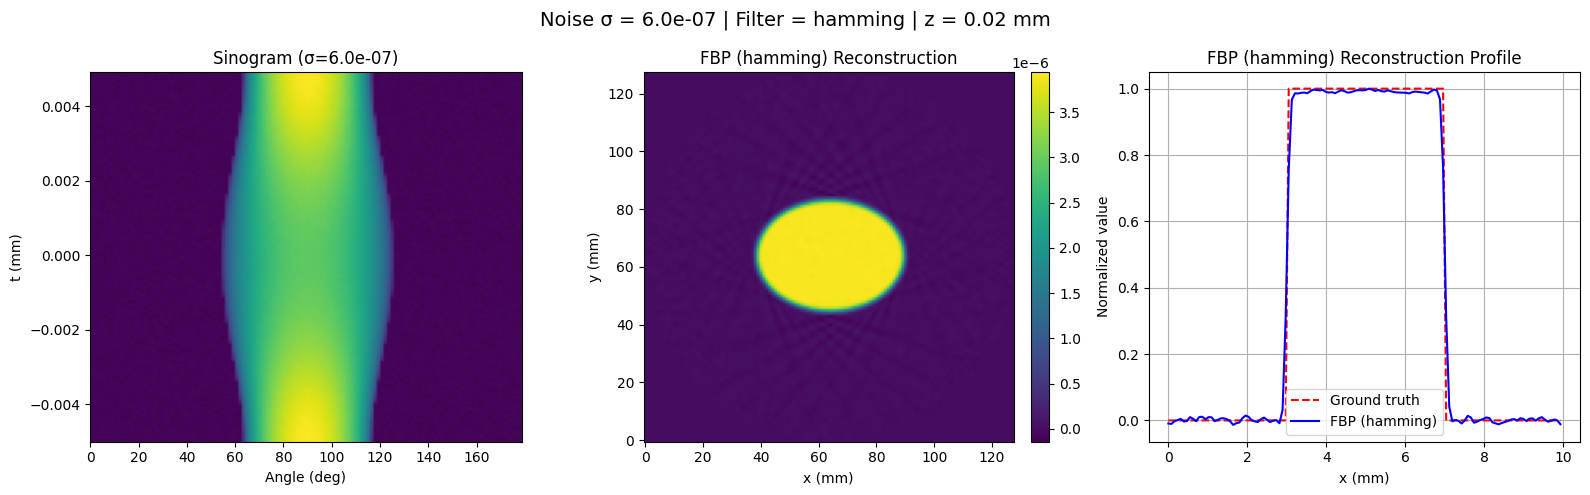

  → Reconstructing with hann filter


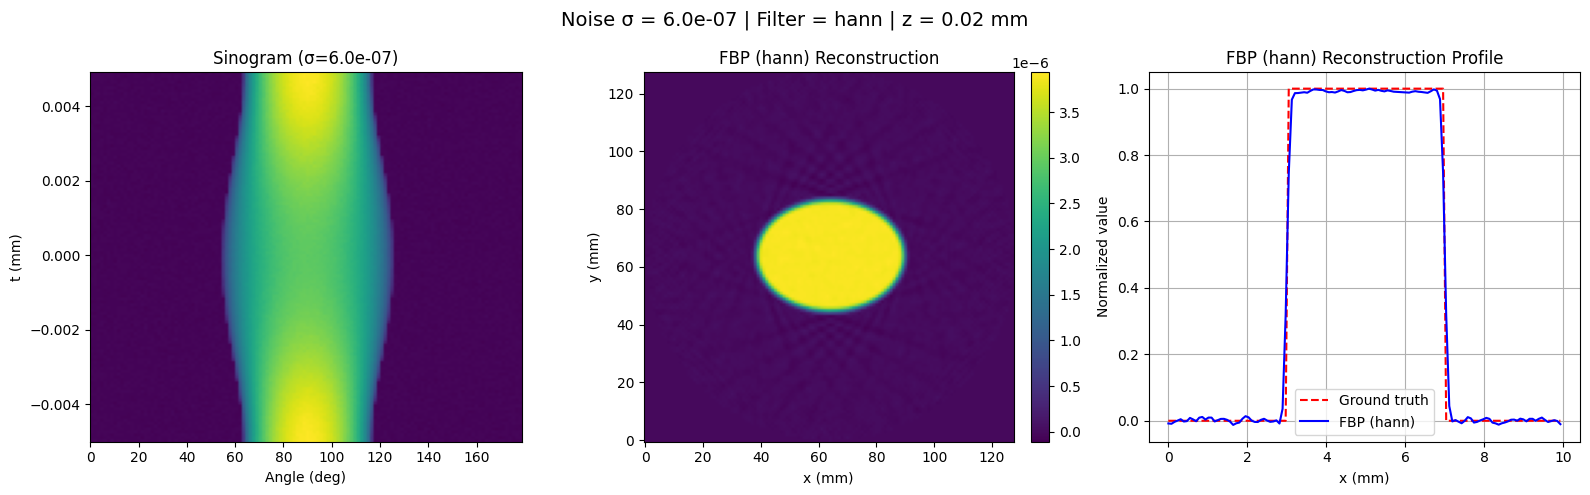


=== Summary of FBP reconstruction metrics ===
Noise(σ)     Filter          NRMSE_FBP (mean±std)      SSIM_FBP (mean±std)       FBP_time(s)
0.00e+00     ramp            0.9999 ± 0.0000           0.9010 ± 0.0396           1.592     
0.00e+00     shepp-logan     0.9999 ± 0.0000           0.9010 ± 0.0396           1.599     
0.00e+00     cosine          0.9999 ± 0.0000           0.9010 ± 0.0396           1.600     
0.00e+00     hamming         0.9999 ± 0.0000           0.9010 ± 0.0396           1.596     
0.00e+00     hann            0.9999 ± 0.0000           0.9010 ± 0.0396           1.598     
1.00e-07     ramp            0.9999 ± 0.0000           0.9010 ± 0.0396           1.595     
1.00e-07     shepp-logan     0.9999 ± 0.0000           0.9010 ± 0.0396           1.595     
1.00e-07     cosine          0.9999 ± 0.0000           0.9010 ± 0.0396           1.603     
1.00e-07     hamming         0.9999 ± 0.0000           0.9010 ± 0.0396           1.613     
1.00e-07     hann            0.9

In [14]:
# --- Prepare summary storage ---
summary_metrics = []

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
noise_levels = [0, 0.1e-6, 0.4e-6, 0.6e-6]

for sigma in noise_levels:

    print(f"\nProcessing noise level sigma={sigma}...")

    # --- Add noise to projections ---
    noisy_projections = additive_noise(projections_2D, sigma, enabled=True)
    sinogram3D = noisy_projections.copy()

    for filt in filters:
        print(f"  → Reconstructing with {filt} filter")

        # --- Reconstruct with specific filter ---
        recon3D, fbp_time = fbp_reconstruct(sinogram3D, angles, nproj, z, y, filter_name=filt)

        # --- Initialize metric lists ---
        SSIM_fbp = []
        NRMSE_fbp = []

        Nx = object3D.shape[1]
        Ny = object3D.shape[0]
        Nz = object3D.shape[2]
        x = np.linspace(0, deltax * (Nx - 1), Nx)

        # --- Calculate metrics over all slices ---
        for zi in range(Nz):
            SSIM_fbp.append(structural_similarity(
                recon3D[:, :, zi],
                object3D[:, :, zi],
                data_range=object3D[:, :, zi].max() - object3D[:, :, zi].min()
            ))
            NRMSE_fbp.append(normalized_root_mse(object3D[:, :, zi], recon3D[:, :, zi]))

        # --- Visualization for mid slice ---
        mid_z = Nz // 2
        mid_y = Ny // 2

        fig, axs = plt.subplots(1, 3, figsize=(16, 5))
        gt_slice = object3D[:, :, mid_z]
        fbp_slice = recon3D[:, :, mid_z]

        # 1D profiles across x
        gt_profile = gt_slice[mid_y, :]
        fbp_profile = fbp_slice[mid_y, :]

        # Normalize profiles (avoid divide by zero)
        if np.max(np.abs(gt_profile)) != 0:
            gt_profile = gt_profile / np.max(np.abs(gt_profile))
        if np.max(np.abs(fbp_profile)) != 0:
            fbp_profile = fbp_profile / np.max(np.abs(fbp_profile))

        # --- Sinogram ---
        axs[0].imshow(
            sinogram3D[:, :, mid_z],
            aspect='auto', cmap='viridis',
            extent=[angles[0], angles[-1], y[0], y[-1]]
        )
        axs[0].set_title(f"Sinogram (σ={sigma:.1e})")
        axs[0].set_xlabel("Angle (deg)")
        axs[0].set_ylabel("t (mm)")

        # --- FBP Reconstruction ---
        im1 = axs[1].imshow(fbp_slice, cmap='viridis', origin='lower')
        axs[1].set_title(f"FBP ({filt}) Reconstruction")
        axs[1].set_xlabel("x (mm)")
        axs[1].set_ylabel("y (mm)")
        fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

        # --- FBP 1D Profile ---
        axs[2].plot(x * 1e3, gt_profile, 'r--', label='Ground truth')
        axs[2].plot(x * 1e3, fbp_profile, 'b-', label=f'FBP ({filt})')
        axs[2].set_title(f"FBP ({filt}) Reconstruction Profile")
        axs[2].set_xlabel("x (mm)")
        axs[2].set_ylabel("Normalized value")
        axs[2].legend()
        axs[2].grid(True)

        plt.suptitle(f"Noise σ = {sigma:.1e} | Filter = {filt} | z = {z[mid_z]*1e3:.2f} mm", fontsize=14)
        plt.tight_layout()
        plt.show()

        # --- Store metrics ---
        summary_metrics.append({
            "sigma": sigma,
            "filter": filt,
            "NRMSE_FBP_mean": np.mean(NRMSE_fbp),
            "NRMSE_FBP_std": np.std(NRMSE_fbp),
            "SSIM_FBP_mean": np.mean(SSIM_fbp),
            "SSIM_FBP_std": np.std(SSIM_fbp),
            "FBP_time": fbp_time
        })

# --- Print summary table ---
print("\n=== Summary of FBP reconstruction metrics ===")
header = ("Noise(σ)", "Filter", "NRMSE_FBP (mean±std)", "SSIM_FBP (mean±std)", "FBP_time(s)")
print("{:<12} {:<15} {:<25} {:<25} {:<10}".format(*header))

for m in summary_metrics:
    print("{:<12.2e} {:<15} {:<25} {:<25} {:<10.3f}".format(
        m["sigma"],
        m["filter"],
        f"{m['NRMSE_FBP_mean']:.4f} ± {m['NRMSE_FBP_std']:.4f}",
        f"{m['SSIM_FBP_mean']:.4f} ± {m['SSIM_FBP_std']:.4f}",
        m["FBP_time"]
    ))


- Fix Ft

-check phantom with high contrast nd things inside

- go over code 




-interpolation methods (girddata linear/ cubic/ regulargridinterpolator)

-forward propagation with born 
-iradon_sart 